# Introduction
### Hi there, welcome to my notebook for the Personalized Medicine Kaggle Competition.
### My general plan when evaluating a new dataset is as follows: first, I try to get an idea of the size and types of data involved, and to discover what sort of signal can be derived which will help during classification. As with this project, sometimes this includes buffering my domain knowledge of the subject. Following that is feature generation, although oftentimes these two parts are commingled. Base features are then evaluated on sample model, the results of which in turn drive further feature modifications. Once I'm happy with a feature set, I'll work on choosing an appropriate model and tuning the hyperparameters.
### I've included in the notebook most parts I took during this process, although some of the more tedious steps are only mentioned. I hope you enjoy going through this as much as I did!

In [567]:
# imports
from collections import defaultdict, Counter
from gensim import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy import optimize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import *

import copy
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import scikitplot.plotters as skplt
import seaborn as sb
import sklearn
import string
import time
import xgboost
import warnings

# configuration
%matplotlib inline
sb.set_style("dark")
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Part 1: Data Discovery

### Load up the data

In [496]:
notebook_start = time.time()
var_train = pd.read_csv('input/training_variants')
var_test = pd.read_csv('input/test_variants')
txt_train = pd.read_csv('input/training_text', sep="\|\|", names=["ID","Text"], skiprows=1)
txt_test = pd.read_csv('input/test_text', sep="\|\|", names=["ID","Text"], skiprows=1)

### Let's look at some basic numbers

In [497]:
print '{} training examples'.format(len(var_train))
print '{} test examples'.format(len(var_test))
print 'Train columns: {}'.format(var_train.columns)
print 'Test columns: {}'.format(var_test.columns)

3321 training examples
5668 test examples
Train columns: Index([u'ID', u'Gene', u'Variation', u'Class'], dtype='object')
Test columns: Index([u'ID', u'Gene', u'Variation'], dtype='object')


### The "variants" data has four entries: ID, Gene, Variation, and Class. The "text" data has ID and text. I'm going to merge these for easier analysis.

In [498]:
train = pd.merge(var_train, txt_train, how='left', on='ID')
test = pd.merge(var_test, txt_test, how='left', on='ID')
all_ = pd.concat([train, test])
num_train = len(train)
num_test = len(test)

assert num_train == len(var_train)
assert num_test == len(var_test)
assert len(all_) == len(var_train) + len(var_test)

display(train.head(3))

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...


### Let's do some basic data cleaning
#### I'm going to avoid lower-casing anything until later, since some information is encoded in the cases. This is especially true for the gene names and variations.

In [499]:
# remove beginning and trailing whitespaces
all_['Gene'] = all_['Gene'].apply(lambda x: x.strip())
all_['Variation'] = all_['Variation'].apply(lambda x: x.strip())
all_['Text'] = all_['Text'].apply(lambda x: x.strip())

### Looking at bad data:

In [500]:
print 'Missing text in training data:'
display(train[train['Text'] == 'null'])

print '\nMissing text in test data:'
display(test[test['Text'] == 'null'])

print '\n{} zero-length strings in Gene (train)'.format(len(train[train['Gene'].apply(len) == 0]))
print '{} zero-length strings in Gene (test)\n'.format(len(test[test['Gene'].apply(len) == 0]))
print '{} zero-length strings in Variation (train)'.format(len(train[train['Variation'].apply(len) == 0]))
print '{} zero-length strings in Variation (test)'.format(len(test[test['Variation'].apply(len) == 0]))

Missing text in training data:


,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,null
1277,1277,ARID5B,Truncating Mutations,1,null
1407,1407,FGFR3,K508M,6,null
1639,1639,FLT1,Amplification,6,null
2755,2755,BRAF,G596C,7,null



Missing text in test data:


,ID,Gene,Variation,Text
1623,1623,AURKB,Amplification,null



0 zero-length strings in Gene (train)
0 zero-length strings in Gene (test)

0 zero-length strings in Variation (train)
0 zero-length strings in Variation (test)


### Some general considerations so far:
#### - There's not a whole lot of data, so I'm going to forego taking too much care with data manipulation techniques (e.g. avoiding too many loops) in favor of more analysis.
#### - Looking at some Text field examples, it appears that these were populated from academic papers.
#### - We may have data points with the same Text field. Depending on how we use the text data, this could become an important factor. For example, if 200 points have the exact same Text, then training a word2vec may bias this is an unintended way.
#### - It looks like there are 5 training data points with a null Text field. This small number isn't a big deal from a training point of view, but we'll have to make sure we account for this during feature generation.
#### - There is likely much information encoded in the Gene and Variation fields, especially when taken together with the Text field.

## Check out class breakdown

There are 9 distinct classes: [1, 2, 3, 4, 5, 6, 7, 8, 9]

Smallest class: 8, with 19 records
Largest class: 7, with 953 records
Largest / smallest ratio: 50.1578947368



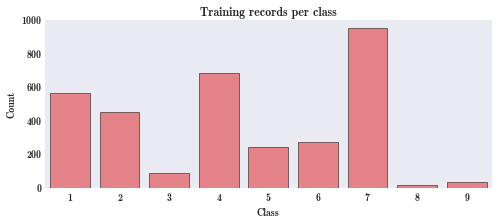

In [705]:
classes = train['Class'].tolist()
class_cnt = Counter(classes)
num_classes = len(class_cnt)
print 'There are {} distinct classes: {}\n'.format(num_classes, sorted(class_cnt))

count_pairs = sorted([ (class_, count) for class_, count in class_cnt.iteritems() ], key=lambda x: x[1])
print 'Smallest class: {}, with {} records'.format(count_pairs[0][0], count_pairs[0][1])
print 'Largest class: {}, with {} records'.format(count_pairs[-1][0], count_pairs[-1][1])
print 'Largest / smallest ratio: {}\n'.format(float(count_pairs[-1][1]) / count_pairs[0][1])

plt.figure(figsize=(8,3))
sb.countplot(classes, color='red', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Class')
plt.title('Training records per class')
plt.show()

#### There appears to be a pretty heavy class imbalance. We'll have to make sure our training data is good enough to correctly classify these. Depending on the model used, we could use some tricks to get more training examples for the underpopulated classes.

## The Gene field

There are 264 unique genes


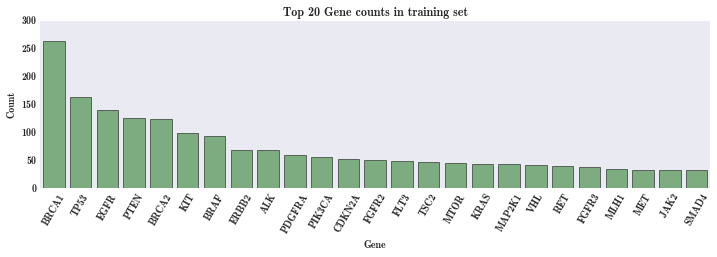

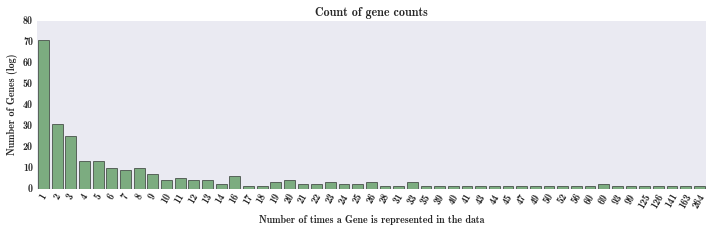

In [727]:
genes = train['Gene'].tolist()
gene_cnt = Counter(genes)

print 'There are {} unique genes'.format(len(gene_cnt))

gene_pairs = sorted([ (class_, count) for class_, count in gene_cnt.iteritems() ], key=lambda x: x[1], reverse=True)
top_to_plot = 25

plt.figure(figsize=(12,3))
sb.countplot(train['Gene'], order=train['Gene'].value_counts().iloc[:top_to_plot].index, color='Green', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Gene')
plt.xticks(rotation=60)
plt.title('Top 20 Gene counts in training set')
plt.show()

plt.figure(figsize=(12,3))
p = sb.countplot(gene_cnt.values(), color='Green', alpha=0.5)
plt.ylabel('Number of Genes')
plt.xlabel('Number of times a Gene is represented in the data')
plt.xticks(rotation=60)
plt.title('Count of gene counts')
plt.show()

### The first plot shows a long tail of genes represented in the data. BRCA1 shows up 264 times. 
### The second plot is a histogram of gene counts in the data. BRCA1 is seen at the very end (the 1 gene visible in 264 data points). There are over 70 genes which only show up once in the data.
### I'd also like to look at the per-class representation of the genes:

In [504]:
# gene-class-counts
gcc = train.groupby(['Gene','Class']).size().reset_index()
gcc.columns = [['Gene','Class','Count']]
print '{} Gene-Class points before filtering'.format(len(gcc))

gcc_fltr = copy.deepcopy(gcc)
gcc_fltr = gcc_fltr[gcc_fltr['Count'] > 1]
gcc_fltr['size'] = np.log2(gcc_fltr['Count']) + 3
print '{} Gene-Class points after filtering'.format(len(gcc_fltr))

590 Gene-Class points before filtering
355 Gene-Class points after filtering


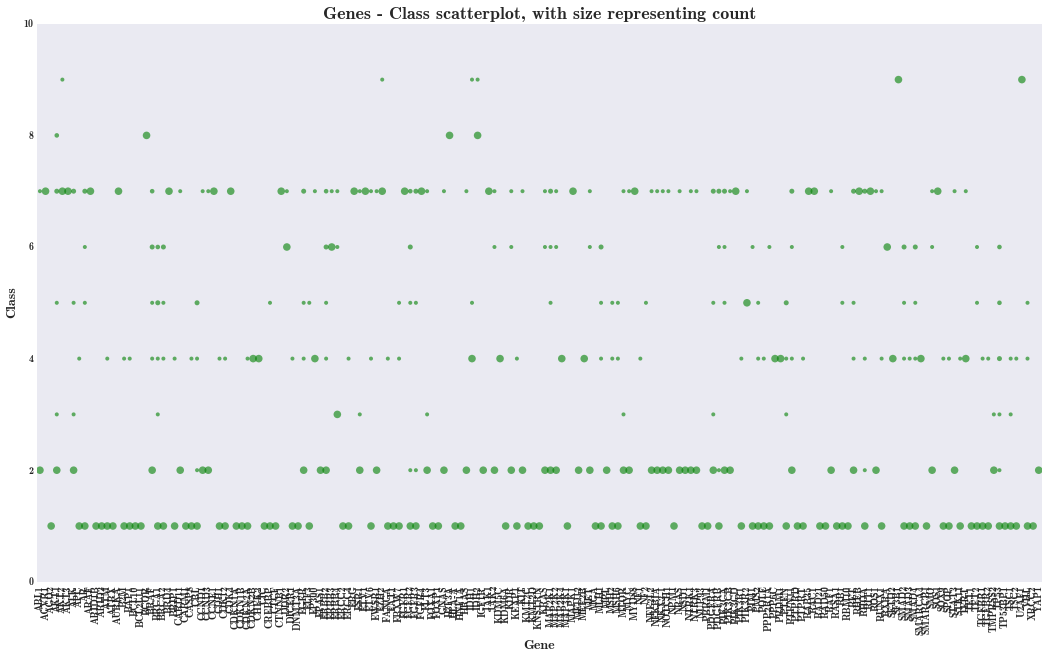

In [707]:
plt.figure(figsize=(18,10))
size = gcc_fltr['size']
sb.stripplot(x=gcc_fltr['Gene'], y=gcc_fltr['Class'], s=size, color='green', alpha=0.6)
plt.xticks(rotation=90)
plt.title('Genes - Class scatterplot, with size representing count', fontsize=18)
plt.xlabel('Gene', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.show()

### In the above plot, the number of data points having the same Gene and Class are represented as the size of the bubble. I've filtered this to only show Gene-Class where the count is greater than 1. There's a lot of information in this, so I'd like to split it out a bit more. Specifically, I'd like to generate numbers on how many classes are spanned per gene.

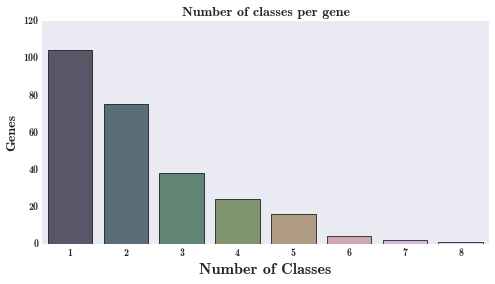

In [708]:
plt.figure(figsize=(8,4))
sb.countplot(gcc.groupby('Gene').size(), palette=sb.color_palette("cubehelix", num_classes), alpha=0.7)
plt.xlabel('Number of Classes', fontsize=16)
plt.ylabel('Genes', fontsize=14)
plt.title('Number of classes per gene', fontsize=14)
plt.show()

### There are a fair amount of multi-class genes. At first glance this plot may suggest that gene is a somewhat strong signal to predict class. However, we need to map this back to a per-data-point representation to get a better idea of the predictive power.

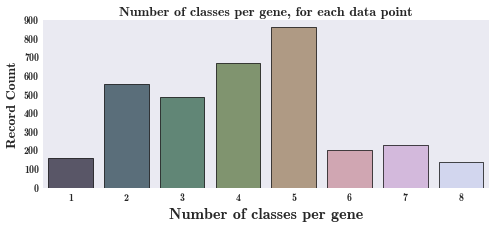

Mean number of classes per gene: 4.13610358326


In [709]:
gcc['Class Count'] = gcc['Class'].groupby(gcc['Gene']).transform('count')
gcc['Total Count'] = gcc['Count'].groupby(gcc['Gene']).transform('sum')
gcc_unique = gcc[['Total Count','Class Count']].groupby(gcc['Gene']).last()

total_counts = []
for x, y in zip(gcc_unique['Class Count'].tolist(), gcc_unique['Total Count'].tolist()):
    total_counts += [x] * y

plt.figure(figsize=(8,3))
sb.countplot(total_counts, palette=sb.color_palette("cubehelix", num_classes), alpha=0.7)
plt.xlabel('Number of classes per gene', fontsize=16)
plt.ylabel('Record Count', fontsize=14)
plt.title('Number of classes per gene, for each data point', fontsize=14)
plt.show()
print 'Mean number of classes per gene: {}'.format(np.mean(total_counts))

### This is a histogram which shows, for each data point, the total number of classes its Gene is associated with. This doesn't look very promising, but there is definitely signal in this worth investigating.

# Browse the Variations field

There are 2996 unique variations


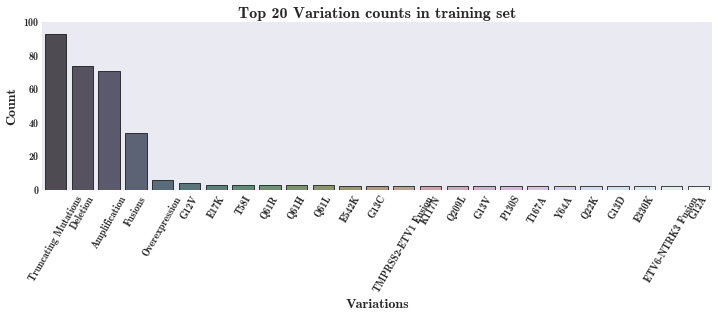

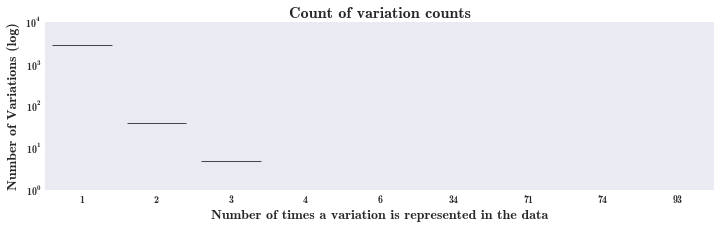

In [710]:
var = train['Variation'].tolist()
var_cnt = Counter(var)

print 'There are {} unique variations'.format(len(var_cnt))

var_pairs = sorted([ (class_, count) for class_, count in var_cnt.iteritems() ], key=lambda x: x[1], reverse=True)

top_to_plot = 25

plt.figure(figsize=(12,3))
sb.countplot(train['Variation'], order=train['Variation'].value_counts().iloc[:top_to_plot].index, palette=sb.color_palette("cubehelix", top_to_plot), alpha=0.7)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Variations', fontsize=14)
plt.xticks(rotation=60)
plt.title('Top 20 Variation counts in training set', fontsize=16)
plt.show()

plt.figure(figsize=(12,3))
p = sb.countplot(var_cnt.values(), palette=sb.color_palette("cubehelix", top_to_plot), alpha=0.7)
p.set_yscale('log')
plt.ylabel('Number of Variations (log)', fontsize=14)
plt.xlabel('Number of times a variation is represented in the data', fontsize=14)
plt.xticks(rotation=0)
plt.title('Count of variation counts', fontsize=16)
plt.show()

### Variations appear to be much more granular than Genes - there are 2996 unique Variations in 3321 data points. Only 4 variations are seen in more than a few data points, and they appear to be non-specific. I'd like to look at these and see which Genes and classes they are associated with.

In [509]:
# variation-gene counts
vcc = train.groupby(['Variation','Gene']).size().reset_index()
vcc.columns = [['Variation','Gene','Count']]
vcc_filt = vcc[vcc['Count'] > 1]

print 'There are {} records after grouping by Gene and Variation.'.format(len(vcc))
print '{} of these have a count higher than 1.'.format(len(vcc_filt))

There are 3321 records after grouping by Gene and Variation.
0 of these have a count higher than 1.


### It appears that every Gene-Variation pair is associated with only one class. This is interesting, despite the fact that there are so many unique Variations. Finally, I'd like to look at the Variations breakdown per class:

In [510]:
# variation-gene counts
vcc = train.groupby(['Variation','Class']).size().reset_index()
vcc.columns = [['Variation','Class','Count']]
vcc_filt = vcc[vcc['Count'] > 1]

print 'There are {} records after grouping by Class and Variation.'.format(len(vcc))
print '{} of these have a count higher than 1.'.format(len(vcc_filt))
print 'Here are the results:\n'
print vcc_filt

There are 3032 records after grouping by Class and Variation.
32 of these have a count higher than 1.
Here are the results:

                      Variation  Class  Count
37                        A146T      7      2
150               Amplification      2     21
151               Amplification      6     10
152               Amplification      7     40
239                       C618R      7      2
476                    Deletion      1     57
477                    Deletion      4     16
523                        E17K      7      3
592                       E542K      7      2
690           ETV6-NTRK3 Fusion      7      2
697           EWSR1-ETV1 Fusion      7      2
755                        F28L      7      2
814                     Fusions      1      2
815                     Fusions      2     31
851                        G12D      7      2
854                        G12S      7      2
855                        G12V      7      4
862                        G13V      2      2
1

### Similar to the Gene grouping, only the non-specific Variations seem to share any classes. I'm going to use this information later during feature generation.

## Look at Text field

In [511]:
print all_.iloc[500]['Text'][:500]

Many p53 missense mutations possess dominant-negative activity and oncogenic gain of function. We report that for structurally destabilized p53 mutants, these effects result from mutant-induced coaggregation of wild-type p53 and its paralogs p63 and p73, thereby also inducing a heat-shock response. Aggregation of mutant p53 resulted from self-assembly of a conserved aggregation-nucleating sequence within the hydrophobic core of the DNA-binding domain, which becomes exposed after mutation. Suppre


### Grepping through the other entries, the Text field appears to be a collection of academic papers. Most of these have to do with mutations associated with various types of cancer. Looking at some numbers:

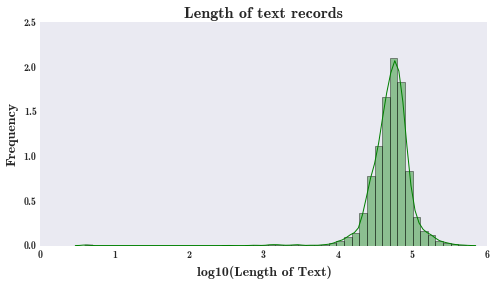

In [711]:
all_['Txt Chrs'] = all_['Text'].apply(lambda x: np.log10(len(x)))

plt.figure(figsize=(8,4))
sb.distplot(all_['Txt Chrs'], bins=50, color='g')
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('log10(Length of Text)', fontsize=14)
plt.title('Length of text records', fontsize=16)
plt.show()

### Most text fields tend to have thousands or tens or thousands of characters. I'm going to look for duplicate Text fields - this may give some insight into the relationships between Gene and Variation.
### To test for uniqueness, I'll create a two-element tuple where the first value is length of the Text field and the second is a string comprising the first 50 characters in the Text field. This is not guaranteed to be unique, but it's probably pretty safe.

In [513]:
all_['Unique Text'] = all_['Text'].apply(lambda x: (len(x), x[:50]))
dupe = all_[['Unique Text','Text','Gene','Variation']].groupby(['Unique Text']).size().reset_index()
dupe.columns = ['Unique Text','Count']
dupe_gene = all_[['Unique Text','Text','Gene','Variation']].groupby(['Unique Text','Gene']).size().reset_index()
dupe_gene.columns = ['Unique Text','Gene','Count']
dupe_var = all_[['Unique Text','Text','Gene','Variation']].groupby(['Unique Text','Variation']).size().reset_index()
dupe_var.columns = ['Unique Text','Variation','Count']
dupe_class = all_[['Unique Text','Text','Class']].groupby(['Unique Text','Class']).size().reset_index()
dupe_class.columns = ['Unique Text','Class','Count']

In [514]:
print 'There are {} duplicate Texts in the combined data set'.format(len(all_) - len(dupe['Unique Text'].tolist()))
print 'There are {} duplicate Texts in the training data set'.format(num_train - 
                                                    len(set(all_[all_['Class'].notnull()]['Unique Text'].tolist())))

There are 1599 duplicate Texts in the combined data set
There are 1400 duplicate Texts in the training data set


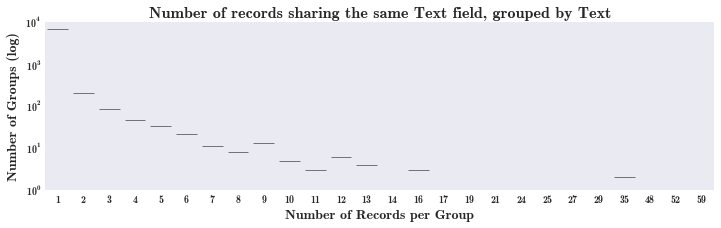

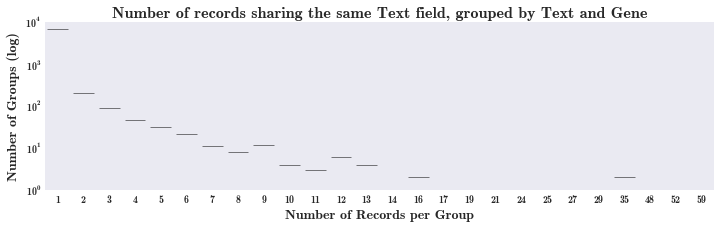

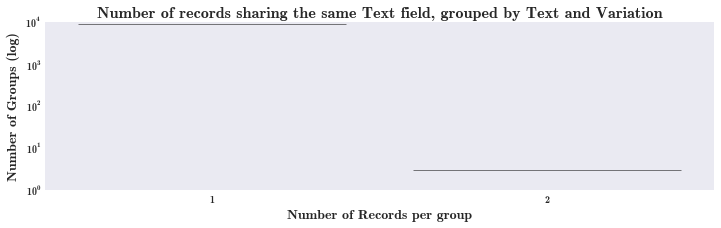

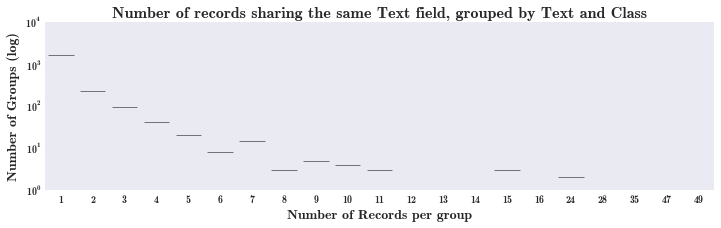

In [734]:
plt.figure(figsize=(12,3))
p = sb.countplot(x='Count', data=dupe, color='purple', alpha=0.5)
p.set_yscale('log')
plt.ylabel('Number of Groups (log)', fontsize=14)
plt.xlabel('Number of Records per Group', fontsize=14)
plt.xticks(rotation=0)
plt.title('Number of records sharing the same Text field, grouped by Text', fontsize=16)
plt.show()

plt.figure(figsize=(12,3))
p = sb.countplot(x='Count', data=dupe_gene, color='purple', alpha=0.5)
p.set_yscale('log')
plt.ylabel('Number of Groups (log)', fontsize=14)
plt.xlabel('Number of Records per Group', fontsize=14)
plt.xticks(rotation=0)
plt.title('Number of records sharing the same Text field, grouped by Text and Gene', fontsize=16)
plt.show()

plt.figure(figsize=(12,3))
p = sb.countplot(x='Count', data=dupe_var, color='purple', alpha=0.5)
p.set_yscale('log')
plt.ylabel('Number of Groups (log)', fontsize=14)
plt.xlabel('Number of Records per group', fontsize=14)
plt.xticks(rotation=0)
plt.title('Number of records sharing the same Text field, grouped by Text and Variation', fontsize=16)
plt.show()

plt.figure(figsize=(12,3))
p = sb.countplot(x='Count', data=dupe_class, color='purple', alpha=0.5)
p.set_yscale('log')
plt.ylabel('Number of Groups (log)', fontsize=14)
plt.xlabel('Number of Records per group', fontsize=14)
plt.xticks(rotation=0)
plt.title('Number of records sharing the same Text field, grouped by Text and Class', fontsize=16)
plt.show()

### It looks like there is some sharing of the Text field between records. Interestingly, it looks like most of the grouping occurs with Gene or Class. Let's investigate these further:

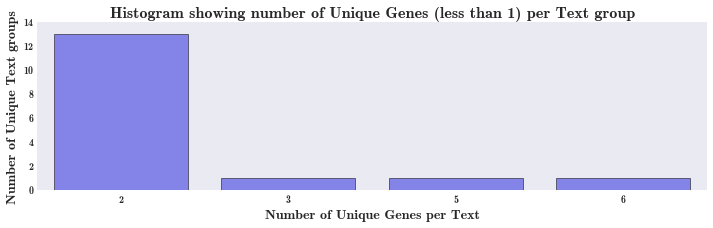

In [733]:
dupe_gene_hist = all_.groupby('Unique Text')['Gene'].apply(lambda x: list(set(x)))
dupe_gene_lists = [ x for x in dupe_gene_hist.values if len(x) > 1]

plt.figure(figsize=(12,3))
p = sb.countplot([ len(x) for x in dupe_gene_lists ], color='blue', alpha=0.5)
plt.xlabel('Number of Unique Genes per Text', fontsize=14)
plt.ylabel('Number of Unique Text groups', fontsize=14)
plt.xticks(rotation=0)
plt.title('Histogram showing number of Unique Genes (less than 1) per Text group', fontsize=16)
plt.show()

### So, we have several instances where the Text field is shared between multiple Genes. Let's look at which genes these are:

In [517]:
for x in dupe_gene_lists:
    print x

['ARID5B', 'FANCA', 'BRAF', 'AURKB', 'FGFR3', 'FLT1']
['SMAD4', 'SMAD2']
['MAP2K2', 'MAP2K1']
['NTRK1', 'FLT3']
['MSH6', 'MLH1']
['SMAD2', 'SMAD3']
['FGFR2', 'FGFR1']
['ERBB2', 'ERBB4']
['PMS2', 'MSH2', 'MSH6']
['CCND3', 'CCND2']
['SMAD4', 'RAC1']
['SMAD4', 'SMAD2']
['AKT1', 'IDH1', 'KRAS', 'NFE2L2', 'FBXW7']
['SMAD4', 'SMAD3']
['SMAD4', 'SMAD2']
['ETV1', 'TMPRSS2']


### A lot of these are what I later identify as "gene families" - an example is SMAD2 and SMAD3, which are part of the SMAD family: https://en.wikipedia.org/wiki/SMAD_(protein). This result provides some justification for this grouping in the next section on feature generation. Let's look at the same breakdown for classes:

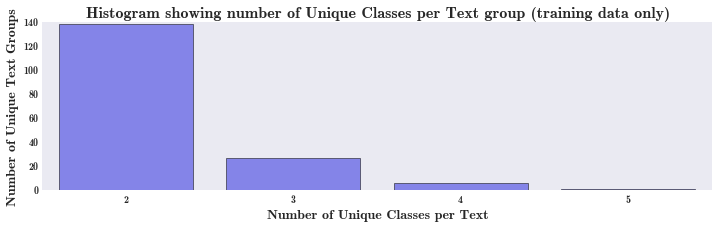

In [735]:
dupe_class_hist = all_.iloc[:num_train].groupby('Unique Text')['Class'].apply(lambda x: list(set(x)))
dupe_class_lists = [ x for x in dupe_class_hist.values if len(x) > 1]

plt.figure(figsize=(12,3))
p = sb.countplot([ len(x) for x in dupe_class_lists ], color='blue', alpha=0.5)
plt.xlabel('Number of Unique Classes per Text', fontsize=14)
plt.ylabel('Number of Unique Text Groups', fontsize=14)
plt.xticks(rotation=0)
plt.title('Histogram showing number of Unique Classes per Text group (training data only)', fontsize=16)
plt.show()

### This last plot shows that the Text field, by itself, does not give enough information to classify all of the data points, and justifies some of the effort I'll spend later in trying to extract information from the Gene and Variation features.
### Now let's try to get a better idea of how we can extract information from the text itself. First we'll do the usual cleaning, normalizing, and tokenizing. We'll probably want to do some removal of common words, but I'd like to look at the distribution of the most popular words first. I'm going to start with removing all punctuation except those found in the Gene and Variation fields:

In [519]:
def clean_and_tokenize(text):
    # keep punctuation used in genes, mutations
    punc_to_clean = ''.join([ x for x in set(string.punctuation) - set(['-','_','*']) ])
    replace_punctuation = string.maketrans(punc_to_clean, ' '*len(punc_to_clean))
    text = text.translate(replace_punctuation)
    return word_tokenize(text.lower())

a = time.time()
all_['Text Tok'] = all_['Text'].apply(clean_and_tokenize)
print 'Took {} seconds'.format(time.time() - a)

Took 325.623804092 seconds


#### Later on I plan to search the text fields for Genes and Variations, so I'll have to remember that I lowercased the text here. Note that I am not filtering out the '-', '_', or '*' characters since these show up in the Gene and Variation fields. I'll likely have to do some removal of standalone instances of dashes afterwards.

In [520]:
all_words = []
for text in all_['Text Tok'].tolist():
    all_words += text

word_cnt = Counter(all_words)
top_words = sorted([ (x, y) for x, y in word_cnt.iteritems() ], key=lambda x: x[1], reverse=True)
print 'There are {} total words in the text'.format(len(all_words))
print 'There are {} unique words in the text'.format(len(word_cnt))

There are 81368956 total words in the text
There are 260387 unique words in the text


#### Look for any misbehaving characters

In [521]:
issues = []
all_words_uni = []
for word in all_words:
    try:
        all_words_uni.append(unicode(word.decode('utf-8')))
    except:
        issues.append(word)
print 'Found {} words with issues out of {}. Kept {} words. Counts:\n'.format(len(issues), len(all_words), len(all_words_uni))
issues_cnt = Counter(issues)
print issues_cnt

Found 3060 words with issues out of 81368956. Kept 81365896 words. Counts:

Counter({'\xbb': 1161, '\xce': 763, '\xab': 369, '\xe2\x84': 165, '-\xc3\x82\xc2': 146, '\xc3\x82\xc2': 81, '\xc2': 58, 'ig\xce': 46, 'ptp\xce': 38, '\xe2\x89': 29, '1\xc3\x82\xc2': 29, 'pelger-hu\xc3': 20, 'er\xc3\x82\xc2': 12, '*-\xc3\x82\xc2': 9, 'la\xc3': 9, '300-\xe2\x84': 8, 'sm-\xce': 7, '\xc3\xa2\xe2\x82\xac\xe2\x80\x9d\xc3\x82\xc2': 7, 'wt\xe2\x89': 6, 'pseudo\xe2\x80\x93pelger-hu\xc3': 6, 'rescue\xc2': 6, 'e\xe2\x88\x92\xce': 6, '*\xc3\x82\xc2': 6, '53\xef\x9a': 6, '\xc3\xa2\xe2\x82\xac\xc2\xa2\xc3\x82\xc2': 6, '\xc3\x82\xc2\xa1\xc3\x82\xc2': 6, '\xe2\xa7': 5, '44\xef\x9a': 5, '133\xef\x9a': 5, '\xe2\x8e': 5, 'h\xc3\x82\xc2': 4, 'b6\xe2\x80\x93\xce': 4, '6t-x1\xc3\x82\xc2': 3, '\xc3\x82\xc2\xbfv\xc3\x82\xc2': 3, '\xc3\xa2\xe2\x80\x9e\xc2\xa2\xc3\x82\xc2': 3, 'v\xce': 3, '208\xc3\x82\xc2': 3, 'um4\xc3\x82\xc2': 3, 'renili\xc3\x82\xc2': 3, 'sammlungfu\xc2': 3, 'ye\xc3\x82\xc2': 1, 'legge\xc3\x82\xc2': 1

### There are a small number of words with troublesome characters. The majority appear to be single-character words, so I'm just going to ignore these characters during the tokenization process later. Visualizing the top words, by count:

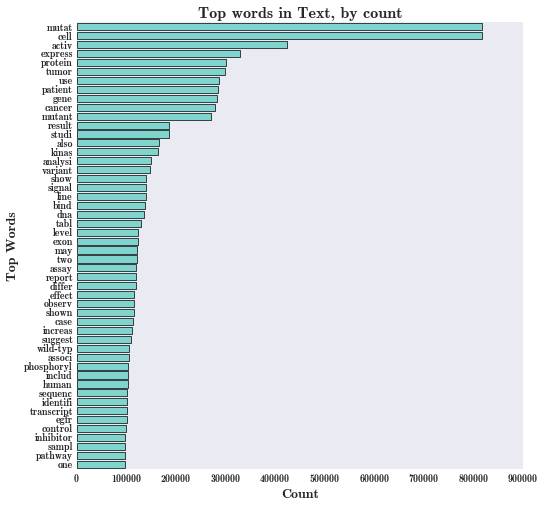

In [736]:
t = pd.DataFrame(top_words[:50], columns=['word','count'])
plt.figure(figsize=(8,8))
p = sb.barplot(y='word', x='count', data=t, color='turquoise', alpha=0.7)
plt.ylabel('Top Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.title('Top words in Text, by count', fontsize=16)
plt.show()

### There are plenty of plain English words, as expected. Since these are unlikely to provide context, we can remove a lot of these. Let's look at 1- and 2-character words, as well, since these are usually not too helpful:

In [523]:
two_chr = [ x for x in all_words_uni if len(x) < 3 and len(x) > 0 ]
two_chr_cnt = Counter(two_chr)
top_two_chr = sorted([ (x, y) for x, y in two_chr_cnt.iteritems() ], key=lambda x: x[1], reverse=True)

print 'There are {} total one/two-character words'.format(len(two_chr))
print 'There are {} unique one/two-character words\n'.format(len(top_two_chr))

There are 18206025 total one/two-character words
There are 2337 unique one/two-character words



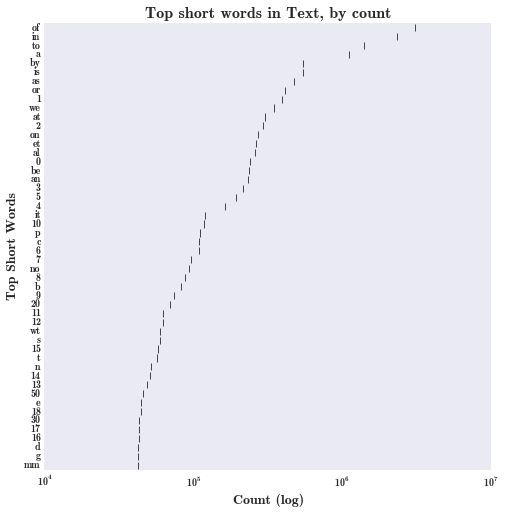

In [737]:
tc = pd.DataFrame(top_two_chr[:50], columns=['word','count'])
plt.figure(figsize=(8,8))
p = sb.barplot(y='word', x='count', data=tc, color='turquoise', alpha=0.7)
p.set_xscale('log')
plt.ylabel('Top Short Words', fontsize=14)
plt.xlabel('Count (log)', fontsize=14)
plt.xticks(rotation=0)
plt.title('Top short words in Text, by count', fontsize=16)
plt.show()

### The top small words by count look like we can remove them. Let's look at the bottom of the list, since two-character words may be important in the context of the papers:

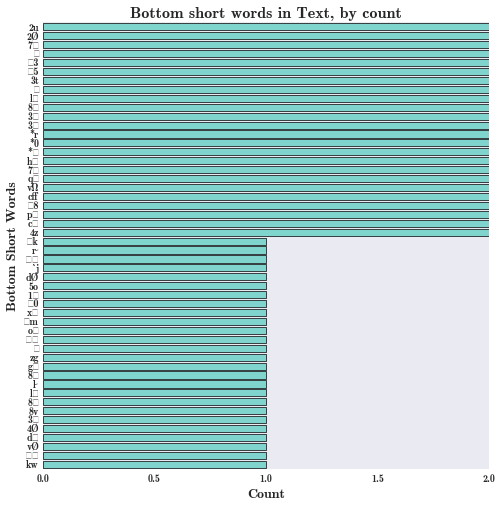

In [738]:
tcb = pd.DataFrame(top_two_chr[-50:], columns=['word','count'])
plt.figure(figsize=(8,8))
p = sb.barplot(y='word', x='count', data=tcb, color='turquoise', alpha=0.7)
plt.ylabel('Bottom Short Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.title('Bottom short words in Text, by count', fontsize=16)
plt.show()

### It's hard to tell by glancing, but these could give important context. I'm going to play it safe by only removing common English stopwords (these contain most of the top 2-character words seen above), single letters, digits less than 100, and common words in scientific papers.

### The last group is found at https://www.victoria.ac.nz/lals/resources/academicwordlist/awl-headwords/Headwords-of-the-Academic-Word-List.pdf, and the contents are copy-pasted here:

In [526]:
academic = 'Headwords of the Academic Word List\nThis list contains the head words of the families in the Academic Word List. The\nnumbers indicate the sublist of the Academic Word List. For example, abandon and\nits family members are in Sublist 8 of the Academic Word List. Sublist 8 is on page\n33 in this book.\nabandon 8\nabstract 6\nacademy 5\naccess 4\naccommodate 9\naccompany 8\naccumulate 8\naccurate 6\nachieve 2\nacknowledge 6\nacquire 2\nadapt 7\nadequate 4\nadjacent 10\nadjust 5\nadministration 2\nadult 7\nadvocate 7\naffect 2\naggregate 6\naid 7\nalbeit 10\nallocate 6\nalter 5\nalternative 3\nambiguous 8\namend 5\nanalogy 9\nanalyse 1\nannual 4\nanticipate 9\napparent 4\nappend 8\nappreciate 8\napproach 1\nappropriate 2\napproximate 4\narbitrary 8\narea 1\naspect 2\nassemble 10\nassess 1\nassign 6\nassist 2\nassume 1\nassure 9\nattach 6\nattain 9\nattitude 4\nattribute 4\nauthor 6\nauthority 1\nautomate 8\navailable 1\naware 5\nbehalf 9\nbenefit 1\nbias 8\nbond 6\nbrief 6\nbulk 9\ncapable 6\ncapacity 5\ncategory 2\ncease 9\nchallenge 5\nchannel 7\nchapter 2\nchart 8\nchemical 7\ncircumstance 3\ncite 6\ncivil 4\nclarify 8\nclassic 7\nclause 5\ncode 4\ncoherent 9\ncoincide 9\ncollapse 10\ncolleague 10\ncommence 9\ncomment 3\ncommission 2\ncommit 4\ncommodity 8\ncommunicate 4\ncommunity 2\ncompatible 9\ncompensate 3\ncompile 10\ncomplement 8\ncomplex 2\ncomponent 3\ncompound 5\ncomprehensive 7\ncomprise 7\ncompute 2\nconceive 10\nconcentrate 4\nconcept 1\nconclude 2\nconcurrent 9\nconduct 2\nconfer 4\nconfine 9\nconfirm 7\nconflict 5\nconform 8\nconsent 3\nconsequent 2\nconsiderable 3\nconsist 1\nconstant 3\nconstitute 1\nconstrain 3\nconstruct 2\nconsult 5\nconsume 2\ncontact 5\ncontemporary 8\ncontext 1\ncontract 1\ncontradict 8\ncontrary 7\ncontrast 4\ncontribute 3\ncontroversy 9\nconvene 3\nconverse 9\nconvert 7\nconvince 10\ncooperate 6\ncoordinate 3\ncore 3\ncorporate 3\ncorrespond3\ncouple 7\ncreate 1\ncredit 2\ncriteria 3\ncrucial 8\nculture 2\ncurrency 8\ncycle 4\ndata 1\ndebate 4\ndecade 7\ndecline 5\ndeduce 3\ndefine 1\ndefinite 7\ndemonstrate 3\ndenote 8\ndeny 7\ndepress 10\nderive 1\ndesign 2\ndespite 4\ndetect 8\ndeviate 8\ndevice 9\ndevote 9\ndifferentiate 7\ndimension 4\ndiminish 9\ndiscrete 5\ndiscriminate 6\ndisplace 8\ndisplay 6\ndispose 7\ndistinct 2\ndistort 9\ndistribute 1\ndiverse 6\ndocument 3\ndomain 6\ndomestic 4\ndominate 3\ndraft 5\ndrama 8\nduration 9\ndynamic 7\neconomy 1\nedit 6\nelement 2\neliminate 7\nemerge 4\nemphasis 3\nempirical 7\nenable 5\nencounter 10\nenergy 5\nenforce 5\nenhance 6\nenormous 10\nensure 3\nentity 5\nenvironment 1\nequate 2\nequip 7\nequivalent 5\nerode 9\nerror 4\nestablish 1\nestate 6\nestimate 1\nethic 9\nethnic 4\nevaluate 2\neventual 8\nevident 1\nevolve 5\nexceed 6\nexclude 3\nexhibit 8\nexpand 5\nexpert 6\nexplicit 6\nexploit 8\nexport 1\nexpose 5\nexternal 5\nextract 7\nfacilitate 5\nfactor 1\nfeature 2\nfederal 6\nfee 6\nfile 7\nfinal 2\nfinance 1\nfinite 7\nflexible 6\nfluctuate 8\nfocus 2\nformat 9\nformula 1\nforthcoming 10\nfoundation 7\nfound 9\nframework 3\nfunction 1\nfund 3\nfundamental 5\nfurthermore 6\ngender 6\ngenerate 5\ngeneration 5\nglobe 7\ngoal 4\ngrade 7\ngrant 4\nguarantee 7\nguideline 8\nhence 4\nhierarchy 7\nhighlight 8\nhypothesis 4\nidentical 7\nidentify 1\nideology 7\nignorance 6\nillustrate 3\nimage 5\nimmigrate 3\nimpact 2\nimplement 4\nimplicate 4\nimplicit 8\nimply 3\nimpose 4\nincentive 6\nincidence 6\nincline 10\nincome 1\nincorporate 6\nindex 6\nindicate 1\nindividual 1\ninduce 8\ninevitable 8\ninfer 7\ninfrastructure 8\ninherent 9\ninhibit 6\ninitial 3\ninitiate 6\ninjure 2\ninnovate 7\ninput 6\ninsert 7\ninsight 9\ninspect 8\ninstance 3\ninstitute 2\ninstruct 6\nintegral 9\nintegrate 4\nintegrity 10\nintelligence 6\nintense 8\ninteract 3\nintermediate 9\ninternal 4\ninterpret 1\ninterval 6\nintervene 7\nintrinsic 10\ninvest 2\ninvestigate 4\ninvoke 10\ninvolve 1\nisolate 7\nissue 1\nitem 2\njob 4\njournal 2\njustify 3\nlabel 4\nlabour 1\nlayer 3\nlecture 6\nlegal 1\nlegislate 1\nlevy 10\nliberal 5\nlicence 5\nlikewise 10\nlink 3\nlocate 3\nlogic 5\nmaintain 2\nmajor 1\nmanipulate 8\nmanual 9\nmargin 5\nmature 9\nmaximise 3\nmechanism 4\nmedia 7\nmediate 9\nmedical 5\nmedium 9\nmental 5\nmethod 1\nmigrate 6\nmilitary 9\nminimal 9\nminimise 8\nminimum 6\nministry 6\nminor 3\nmode 7\nmodify 5\nmonitor 5\nmotive 6\nmutual 9\nnegate 3\nnetwork 5\nneutral 6\nnevertheless 6\nnonetheless 10\nnorm 9\nnormal 2\nnotion 5\nnotwithstanding 10\nnuclear 8\nobjective 5\nobtain 2\nobvious 4\noccupy 4\noccur 1\nodd 10\noffset 8\nongoing 10\noption 4\norient 5\noutcome 3\noutput 4\noverall 4\noverlap 9\noverseas 6\npanel 10\nparadigm 7\nparagraph 8\nparallel 4\nparameter 4\nparticipate 2\npartner 3\npassive 9\nperceive 2\npercent 1\nperiod 1\npersist 10\nperspective 5\nphase 4\nphenomenon 7\nphilosophy 3\nphysical 3\nplus 8\npolicy 1\nportion 9\npose 10\npositive 2\npotential 2\npractitioner 8\nprecede 6\nprecise 5\npredict 4\npredominant 8\npreliminary 9\npresume 6\nprevious 2\nprimary 2\nprime 5\nprincipal 4\nprinciple 1\nprior 4\npriority 7\nproceed 1\nprocess 1\nprofessional 4\nprohibit 7\nproject 4\npromote 4\nproportion 3\nprospect 8\nprotocol 9\npsychology 5\npublication 7\npublish 3\npurchase 2\npursue 5\nqualitative 9\nquote 7\nradical 8\nrandom 8\nrange 2\nratio 5\nrational 6\nreact 3\nrecover 6\nrefine 9\nregime 4\nregion 2\nregister 3\nregulate 2\nreinforce 8\nreject 5\nrelax 9\nrelease 7\nrelevant 2\nreluctance 10\nrely 3\nremove 3\nrequire 1\nresearch 1\nreside 2\nresolve 4\nresource 2\nrespond 1\nrestore 8\nrestrain 9\nrestrict 2\nretain 4\nreveal 6\nrevenue 5\nreverse 7\nrevise 8\nrevolution 9\nrigid 9\nrole 1\nroute 9\nscenario 9\nschedule 8\nscheme 3\nscope 6\nsection 1\nsector 1\nsecure 2\nseek 2\nselect 2\nsequence 3\nseries 4\nsex 3\nshift 3\nsignificant 1\nsimilar 1\nsimulate 7\nsite 2\nso-called 10\nsole 7\nsomewhat 7\nsource 1\nspecific 1\nspecify 3\nsphere 9\nstable 5\nstatistic 4\nstatus 4\nstraightforward 10\nstrategy 2\nstress 4\nstructure 1\nstyle 5\nsubmit 7\nsubordinate 9\nsubsequent 4\nsubsidy 6\nsubstitute 5\nsuccessor 7\nsufficient 3\nsum 4\nsummary 4\nsupplement 9\nsurvey 2\nsurvive 7\nsuspend 9\nsustain 5\nsymbol 5\ntape 6\ntarget 5\ntask 3\nteam 9\ntechnical 3\ntechnique 3\ntechnology 3\ntemporary 9\ntense 8\nterminate 8\ntext 2\ntheme 8\ntheory 1\nthereby 8\nthesis 7\ntopic 7\ntrace 6\ntradition 2\ntransfer 2\ntransform 6\ntransit 5\ntransmit 7\ntransport 6\ntrend 5\ntrigger 9\nultimate 7\nundergo 10\nunderlie 6\nundertake 4\nuniform 8\nunify 9\nunique 7\nutilise 6\nvalid 3\nvary 1\nvehicle 8\nversion 5\nvia 8\nviolate 9\nvirtual 8\nvisible 7\nvision 9\nvisual 8\nvolume 3\nvoluntary 7\nwelfare 5\nwhereas 5\nwhereby 10\nwidespread 8\n' 

In [527]:
academic_words = [ x.strip().split(' ')[0].lower() for x in academic.split('\n')[5:-1] ]
print 'Examples of common academic words:\n'
for x in sorted(academic_words)[250:255]:
    print x

Examples of common academic words:

goal
grade
grant
guarantee
guideline


### I think word stopping is going to be very important for this, given the large size of each text field. The key is going to be to extract as much relevant information as possible from the text, so removing words with little lexical content is important. I may revisit this after getting some initial results.

In [528]:
stemmer = LancasterStemmer()
stop_words = stopwords.words('english')
stop_words += [str(x) for x in range(100)]
stop_words += ['fig','figure','et','al','-','\xe2\x88\x92'] # I should be handling unicode better
stop_words += list(string.ascii_lowercase)
stop_words += academic_words
stop_words = set(stop_words)
print 'We are filtering out {} stop words'.format(len(stop_words))

We are filtering out 847 stop words


### I'd also like to look at stemming as a means of grouping together similar words. Let's try a few stemming methods on the top filtered words:

In [529]:
top_words_stopped = [ x for x in top_words if x[0] not in stop_words ]
top = pd.DataFrame(top_words_stopped[:20], columns=['word','count'])

isri_stemmer = ISRIStemmer()
lancaster_stemmer = LancasterStemmer()
porter_stemmer = PorterStemmer()

top['ISRI'] = top['word'].apply(lambda x: isri_stemmer.stem(x))
top['Lancaster'] = top['word'].apply(lambda x: lancaster_stemmer.stem(x))
top['Porter'] = top['word'].apply(lambda x: porter_stemmer.stem(x))
print top

          word   count        ISRI Lancaster   Porter
0    mutations  508812   mutations       mut    mutat
1        cells  507825       cells       cel     cell
2         cell  309704        cell       cel     cell
3     mutation  249853    mutation       mut    mutat
4       cancer  224848      cancer      cant   cancer
5     patients  219502    patients      paty  patient
6   expression  219369  expression   express  express
7      protein  200723     protein   protein  protein
8         gene  169570        gene       gen     gene
9     activity  165902    activity       act    activ
10        also  165496        also      also     also
11       using  164915       using        us      use
12      mutant  160270      mutant       mut   mutant
13       tumor  159284       tumor       tum    tumor
14    analysis  150499    analysis    analys  analysi
15      kinase  139288      kinase     kinas    kinas
16      tumors  138500      tumors       tum    tumor
17         dna  133366      

### The Lancaster stemmer seems a bit aggressive - "mutation" becomes "mut", and "cancer" becomes "cant", which is odd. The ISRI stemmer doesn't quite seem aggressive enough, and it doesn't remove pluralizations. The Porter stemmer looks like it will consolidate the most information without losing context.

### Now that we have a reasonable plan, let's re-write the clean-up method and look at the top words again:

In [530]:
def clean_and_tokenize_new(text):
    punc_to_clean = ''.join([ x for x in set(string.punctuation) - set(['-','_','*']) ])
    replace_punctuation = string.maketrans(punc_to_clean, ' '*len(punc_to_clean))
    text = text.translate(replace_punctuation)
    tokens = word_tokenize(text.lower())
    stemmed_words = []
    for word in tokens:
        if word not in stop_words:
            try:
                stemmed_words.append(porter_stemmer.stem(unicode(word.decode('utf-8'))))
            except:
                pass
    return stemmed_words

a = time.time()
all_['Text Tok'] = all_['Text'].apply(clean_and_tokenize_new)
print 'Took {} seconds'.format(time.time() - a)

Took 1362.56393909 seconds


#### Kind of slow - If my data set were significantly larger I'd throw this in Spark and parallelize it.

In [531]:
all_words = []
for text in all_['Text Tok'].tolist():
    all_words += text

word_cnt = Counter(all_words)
top_words = sorted([ (x, y) for x, y in word_cnt.iteritems() ], key=lambda x: x[1], reverse=True)
print 'There are {} total words in the text'.format(len(all_words))
print 'There are {} unique words in the text'.format(len(word_cnt))

There are 46555054 total words in the text
There are 241633 unique words in the text


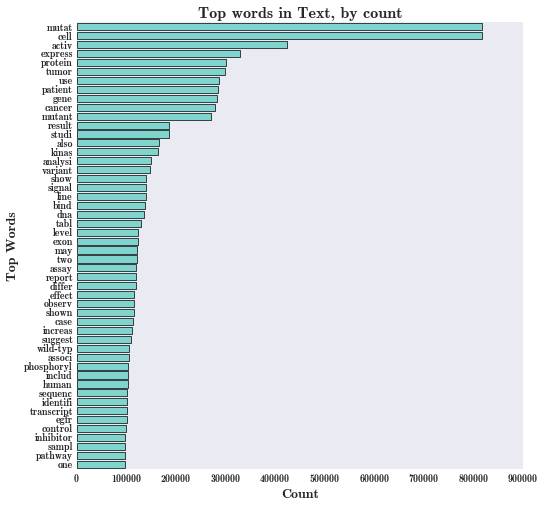

In [739]:
tcb = pd.DataFrame(top_words[:50], columns=['word','count'])
plt.figure(figsize=(8,8))
p = sb.barplot(y='word', x='count', data=tcb, color='turquoise', alpha=0.7)
plt.ylabel('Top Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.title('Top words in Text, by count', fontsize=16)
plt.show()

### That's more like it! Much more can be done to improve upon the long tail, but we'll stop for now. Some thoughts on these results:
#### - Among the top stems are "mutat", "activ", "gene", "cancer", "mutant", and "variant". These seem like decent starting points for a more targeted text analysis. A simple basis for feature extraction I may try later would be to combine the 10 words before and after every instance of these words into a list and run a Bag of Words or TF-IDF on the resulting word vector.
#### - A method like TF-IDF would automatically generate relevance scores for terms, and may find informative terms that I dropped. An example is negation - "did not mutate" is pretty different than "mutate". An LSTM may work well due to the sequential nature of the data.

# Part 2: Feature Generation

### My genetics background is somewhat limited, but we can infer some information from the data given. For each of the features below, I've written some justification for their inclusion. I've also added citations for knowledge that I gained during the research phase.
### Note: for each of the features below, I performed some careful validation to make sure they turned out as expected. I have omitted most of this validation in the notebook. 

## Features: Gene / Variation numbers, length of Gene / Variation
#### Things like string length are very basic and, at least for the present application, don't have much intuition behind them, but it's always worth checking out features like these. It may just end up encoding some of the other features I'm trying to create (e.g. "Amplification" is longer than "D331G". The existence of numbers does have some meaning in gene naming, so my hope is that we can capture some of that information with this feature. Ideally we'd try to sub-group gene families by these numbers, but that requires pulling external data, so I'll revisit that only if I have time.

In [533]:
def gene_num_numbers(x):
    int_match = re.findall(r'\d+', x)
    return len(int_match)

def var_num_numbers(x):
    int_match = re.findall(r'\d+', x)
    return len(int_match)

assert 2 == gene_num_numbers('NKX2-1')
assert 1 == gene_num_numbers('EIF1AX')
assert 0 == gene_num_numbers('HLA-A')
assert 2 == var_num_numbers('963_D1010splice')
assert 1 == var_num_numbers('D331G')
assert 1 == var_num_numbers('Exon 13 Deletions')
assert 0 == var_num_numbers('BCAN-NTRK Fusion')

all_['F-Gene Num Nums'] = all_['Gene'].apply(gene_num_numbers)
all_['F-Var Num Nums']  = all_['Variation'].apply(var_num_numbers)
all_['F-Gene Len']      = all_['Gene'].apply(lambda x: len(x))
all_['F-Var Len']       = all_['Variation'].apply(lambda x: len(x))

## Features: Encoded Gene, Variation
### For categorical data, I usually try and stick to a one-hot encoding. However, there are over 1500 unique genes and nearly 9000 variations in the data set for about 9000 data points. This dimension/feature ratio is too high for the amount of data (the ratio is similar for the training-only data). I'm going to try a binary encoding scheme - this will hopefully retain much of the the information available with a one-hot encoding, while keeping the required features to log2(num_genes+num_variations).
### I'll also note that, based on the data discovery in the above section, there is likely little information to be gained by including by encoding the Variation name. I'd like to test this out later, but it is low priority.

In [534]:
def make_binary(x, digits):
    bin_str = '{0:b}'.format(x)[::-1] # inverse it for convenience
    for i in range(digits-len(bin_str)):
        bin_str += '0'
    return bin_str

assert '01000111101' == make_binary(1506, 11)
assert '00000000000' == make_binary(0, 11)
e = preprocessing.LabelEncoder()

In [535]:
encoded_genes = set(e.fit_transform(all_['Gene']).tolist())
num_gene_encodings = int(math.ceil(np.log2(len(encoded_genes))))
print 'There are {} unique genes in the combined train & test sets'.format(len(encoded_genes))
print 'We need {} digits for gene encodings'.format(num_gene_encodings)

all_['Enc Gene'] = e.fit_transform(all_['Gene']) + 1
all_['Enc Gene'] = all_['Enc Gene'].apply(lambda x: make_binary(x, num_gene_encodings))

for i in range(num_gene_encodings):
    all_['F-EG{}'.format(i+1)] = all_.apply(lambda x: float(x['Enc Gene'][i]), axis=1)

There are 1507 unique genes in the combined train & test sets
We need 11 digits for gene encodings


In [536]:
encoded_vars = set(e.fit_transform(all_['Variation']).tolist())
num_var_encodings = int(math.ceil(np.log2(len(encoded_vars))))
print 'There are {} unique variations in the combined train & test sets'.format(len(encoded_vars))
print 'We need {} digits for variation encodings'.format(num_var_encodings)

all_['Enc Var'] = e.fit_transform(all_['Variation']) + 1
all_['Enc Var'] = all_['Enc Var'].apply(lambda x: make_binary(x, num_var_encodings))

for i in range(num_var_encodings):
    all_['F-EV{}'.format(i+1)] = all_.apply(lambda x: float(x['Enc Var'][i]), axis=1)

There are 8609 unique variations in the combined train & test sets
We need 14 digits for variation encodings


## Feature: Encoded Gene family
### Many of these genes are members of gene families - an example is FGFR: https://en.wikipedia.org/wiki/Fibroblast_growth_factor_receptor. Genes in families can have similar functions, so this may provide a useful grouping. Parsing out the numbers may work - e.g. with BRCA1 and BRCA2. After we identify the gene family, we should encode them to a numerical feature. Other options include n-gram similarity and edit distance metrics, but I will try this method instead.

In [537]:
def gene_family(x):
    int_match = re.findall(r'\d.*$', x)
    if len(int_match) == 0:
        return x
    for im in int_match:
        if x.startswith(im):
            continue
        if x.endswith(im):
            return x[:-len(im)]
    return x

assert 'BRCA' == gene_family('BRCA1')
assert 'BRCA' == gene_family('BRCA23')
assert '24BRCA' == gene_family('24BRCA')
assert 'BRCA' == gene_family('BRCA2A')

all_['Gene Fam'] = all_['Gene'].apply(gene_family)

encoded_gene_fams = set(e.fit_transform(all_['Gene Fam']).tolist())
num_gene_fam_encodings = int(math.ceil(np.log2(len(encoded_gene_fams))))
print 'There are {} unique gene families in the combined train & test sets'.format(len(encoded_gene_fams))
print 'We need {} digits for gene family encodings'.format(num_gene_fam_encodings)

all_['GFE'] = e.fit_transform(all_['Gene Fam'])
all_['GFE'] = all_['GFE'].apply(lambda x: make_binary(x, num_gene_fam_encodings))

for i in range(num_gene_fam_encodings):
    all_['F-EGF{}'.format(i+1)] = all_.apply(lambda x: float(x['GFE'][i]), axis=1)

There are 1060 unique gene families in the combined train & test sets
We need 11 digits for gene family encodings


## Features: First, Last Variant Letter for Substitution
#### The general format for a substitution, which appears to be the the most common type of variation in this data set, is represented by the general formula: {amino_acid_being_replaced}{number_in_sequence}{replacing_amino_acid}, e.g. "Y901C" - http://varnomen.hgvs.org/recommendations/DNA/variant/substitution/. So, we can derive three features from this type of mutation: "AA1", "AA2", and "location". To use the location feature in any meaningful way, I will have to perform some mapping for this number and/or use the total length of the gene. I'm skipping this for now, since a cursory review of the literature didn't provide much information.
#### I'm going to one-hot encode these. This will add an additional 42 features - 20 amino acids plus 1 default for the first and last characters.

In [538]:
def end_variant_letter(x, pos, skips, valid_letters, punctuation):
    default = '0'
    for word in skips:
        if word in x.lower():
            return default
    int_match = re.findall(r'\d+', x)
    if len(int_match) > 0 \
        and x[0] in valid_letters \
        and (x[-1] in valid_letters or len(set(x) & set(punctuation)) > 0):
            if pos == 'first':
                return x[0]
            elif pos == 'last':
                return x[-1]
    return default

# I just did a quick manual search for these skip words. If the data set was significantly
# larger, I'd go with an English and/or scientific dictionary lookup to automate this.
skip_words_first = ['amplific','copy','dna','deletion','delta','epigenetic','exon', \
                    'fusion','hypermeth','over','promote','single','truncat','wild']
amino_acid_letters = 'ACDEFGHIKLMNPQRSTVWY'
special_punc = ['_']

assert 'A' == end_variant_letter('A1065T', 'first', skip_words_first, amino_acid_letters, special_punc)
assert '0' == end_variant_letter('385_418del', 'first', skip_words_first, amino_acid_letters, special_punc)
assert 'A' == end_variant_letter('A750_E758del', 'first', skip_words_first, amino_acid_letters, special_punc)

In [539]:
all_['FL'] = all_['Variation'].apply(lambda x: end_variant_letter(x, 'first', skip_words_first, amino_acid_letters, special_punc))
all_['LL'] = all_['Variation'].apply(lambda x: end_variant_letter(x, 'last', skip_words_first, amino_acid_letters, special_punc))

default = '0'
aa_values = list(amino_acid_letters) + [default]

for aa in aa_values:
    all_['F-FL-{}'.format(aa)] = all_.apply(lambda x: 1.0 if x['FL'] == aa else 0.0, axis=1)
for aa in aa_values:
    all_['F-LL-{}'.format(aa)] = all_.apply(lambda x: 1.0 if x['LL'] == aa else 0.0, axis=1)

## Feature: Correlation between Amino Acids

#### This feature is derived from what is essentially the likelihood of mutations between pairs: https://www.ncbi.nlm.nih.gov/pubmed/4843792. I came across this while trying to figure out ways to group records by Variation.
#### The following dictionary was grabbed from https://gist.github.com/arq5x/5408712. Since a higher number is associated with a higher frequency of mutation, I'll set the default value to 0.

In [540]:
aa_lookup = {('S', 'W'): '177', ('G', 'G'): '0', ('E', 'M'): '126', ('A', 'N'): '111', ('A', 'Y'): '112', ('W', 'Q'): '130', ('V', 'N'): '133', ('F', 'K'): '102', ('G', 'E'): '98', ('E', 'D'): '45', ('W', 'P'): '147', ('I', 'T'): '89', ('F', 'D'): '177', ('K', 'V'): '97', ('C', 'Y'): '194', ('G', 'D'): '94', ('T', 'N'): '65', ('W', 'W'): '0', ('S', 'S'): '0', ('K', 'C'): '202', ('E', 'F'): '140', ('N', 'L'): '153', ('A', 'K'): '106', ('Q', 'P'): '76', ('F', 'G'): '153', ('D', 'S'): '65', ('C', 'V'): '192', ('V', 'T'): '69', ('H', 'P'): '77', ('P', 'V'): '68', ('I', 'Q'): '109', ('F', 'V'): '50', ('W', 'T'): '128', ('H', 'F'): '100', ('P', 'D'): '108', ('Q', 'R'): '43', ('D', 'Q'): '61', ('K', 'Q'): '53', ('D', 'F'): '177', ('V', 'W'): '88', ('T', 'C'): '149', ('A', 'F'): '113', ('T', 'H'): '47', ('A', 'Q'): '91', ('Q', 'T'): '42', ('V', 'F'): '50', ('F', 'C'): '205', ('C', 'R'): '180', ('V', 'P'): '68', ('H', 'T'): '47', ('E', 'L'): '138', ('F', 'R'): '97', ('I', 'G'): '135', ('C', 'Q'): '154', ('Y', 'V'): '55', ('T', 'A'): '58', ('T', 'V'): '69', ('Q', 'V'): '96', ('S', 'K'): '121', ('K', 'K'): '0', ('E', 'N'): '42', ('N', 'T'): '65', ('A', 'H'): '86', ('A', 'C'): '195', ('V', 'S'): '124', ('Q', 'H'): '24', ('H', 'S'): '89', ('Q', 'Y'): '99', ('P', 'N'): '91', ('I', 'Y'): '33', ('P', 'G'): '42', ('F', 'N'): '158', ('H', 'N'): '68', ('K', 'H'): '32', ('N', 'W'): '174', ('S', 'Y'): '144', ('W', 'N'): '174', ('D', 'Y'): '160', ('E', 'Q'): '29', ('K', 'Y'): '85', ('S', 'G'): '56', ('Y', 'S'): '144', ('G', 'R'): '125', ('A', 'L'): '96', ('A', 'G'): '60', ('T', 'K'): '78', ('T', 'P'): '38', ('M', 'V'): '21', ('Q', 'L'): '113', ('E', 'S'): '80', ('H', 'W'): '115', ('I', 'D'): '168', ('K', 'F'): '102', ('N', 'A'): '111', ('T', 'I'): '89', ('Q', 'N'): '46', ('K', 'W'): '110', ('S', 'C'): '112', ('Y', 'Y'): '0', ('G', 'V'): '109', ('L', 'V'): '32', ('A', 'R'): '112', ('M', 'R'): '91', ('Y', 'L'): '36', ('D', 'C'): '154', ('P', 'P'): '0', ('D', 'H'): '81', ('Q', 'Q'): '0', ('I', 'V'): '29', ('P', 'F'): '114', ('I', 'A'): '94', ('F', 'F'): '0', ('K', 'T'): '78', ('L', 'T'): '92', ('S', 'Q'): '68', ('W', 'F'): '40', ('D', 'A'): '126', ('E', 'Y'): '122', ('K', 'A'): '106', ('Q', 'S'): '68', ('A', 'D'): '126', ('L', 'R'): '102', ('T', 'S'): '58', ('A', 'V'): '64', ('M', 'N'): '142', ('Q', 'D'): '61', ('E', 'P'): '93', ('V', 'V'): '0', ('D', 'N'): '23', ('I', 'S'): '142', ('P', 'M'): '87', ('H', 'D'): '81', ('I', 'L'): '5', ('K', 'N'): '94', ('L', 'P'): '98', ('Y', 'I'): '33', ('N', 'I'): '149', ('T', 'Q'): '42', ('Q', 'F'): '116', ('S', 'M'): '135', ('E', 'R'): '54', ('Q', 'W'): '130', ('G', 'N'): '80', ('L', 'Y'): '36', ('L', 'N'): '153', ('A', 'S'): '99', ('D', 'T'): '85', ('S', 'T'): '58', ('P', 'S'): '74', ('V', 'R'): '96', ('D', 'K'): '101', ('P', 'H'): '77', ('H', 'C'): '174', ('Q', 'I'): '109', ('H', 'H'): '0', ('I', 'I'): '0', ('L', 'W'): '61', ('L', 'L'): '0', ('D', 'R'): '96', ('S', 'I'): '142', ('D', 'I'): '168', ('E', 'A'): '107', ('K', 'I'): '102', ('Q', 'K'): '53', ('T', 'D'): '85', ('A', 'W'): '148', ('Y', 'R'): '77', ('M', 'F'): '28', ('S', 'P'): '74', ('H', 'Q'): '24', ('Y', 'N'): '143', ('I', 'P'): '95', ('E', 'C'): '170', ('H', 'G'): '98', ('P', 'E'): '93', ('Q', 'M'): '101', ('H', 'L'): '99', ('L', 'S'): '145', ('L', 'H'): '99', ('N', 'Q'): '46', ('T', 'Y'): '92', ('K', 'G'): '127', ('S', 'E'): '80', ('Y', 'E'): '122', ('W', 'R'): '101', ('V', 'M'): '21', ('N', 'R'): '86', ('G', 'F'): '153', ('F', 'Y'): '22', ('L', 'Q'): '113', ('M', 'Y'): '36', ('A', 'P'): '27', ('S', 'N'): '46', ('C', 'L'): '198', ('L', 'F'): '22', ('D', 'W'): '181', ('S', 'L'): '145', ('P', 'R'): '103', ('P', 'K'): '103', ('Y', 'G'): '147', ('C', 'K'): '202', ('H', 'K'): '32', ('Q', 'A'): '91', ('I', 'F'): '21', ('K', 'D'): '101', ('N', 'C'): '139', ('L', 'D'): '172', ('Y', 'K'): '85', ('S', 'A'): '99', ('W', 'V'): '88', ('E', 'I'): '134', ('V', 'I'): '29', ('Q', 'C'): '154', ('T', 'G'): '59', ('T', 'L'): '92', ('L', 'M'): '15', ('A', 'T'): '58', ('C', 'H'): '174', ('P', 'Y'): '110', ('S', 'H'): '89', ('H', 'Y'): '83', ('E', 'K'): '56', ('C', 'G'): '159', ('I', 'C'): '198', ('Q', 'E'): '29', ('K', 'R'): '26', ('T', 'E'): '65', ('L', 'K'): '107', ('M', 'W'): '67', ('N', 'Y'): '143', ('N', 'H'): '68', ('V', 'E'): '121', ('Q', 'G'): '87', ('Y', 'D'): '160', ('F', 'Q'): '116', ('G', 'Y'): '147', ('L', 'I'): '5', ('M', 'Q'): '101', ('R', 'A'): '112', ('C', 'D'): '154', ('S', 'V'): '124', ('D', 'D'): '0', ('S', 'D'): '65', ('P', 'C'): '169', ('C', 'C'): '0', ('W', 'K'): '110', ('I', 'N'): '149', ('K', 'L'): '107', ('N', 'K'): '94', ('L', 'G'): '138', ('M', 'S'): '135', ('R', 'C'): '180', ('R', 'D'): '96', ('V', 'A'): '64', ('W', 'I'): '61', ('T', 'T'): '0', ('F', 'M'): '28', ('L', 'E'): '138', ('M', 'M'): '0', ('R', 'E'): '54', ('W', 'H'): '115', ('S', 'R'): '110', ('E', 'W'): '152', ('P', 'Q'): '76', ('H', 'A'): '86', ('Y', 'A'): '112', ('E', 'H'): '40', ('R', 'F'): '97', ('I', 'K'): '102', ('N', 'E'): '42', ('T', 'M'): '81', ('T', 'R'): '71', ('M', 'T'): '81', ('G', 'S'): '56', ('L', 'C'): '198', ('R', 'G'): '125', ('Y', 'M'): '36', ('N', 'F'): '158', ('Y', 'Q'): '99', ('N', 'P'): '91', ('R', 'H'): '29', ('W', 'M'): '67', ('C', 'N'): '139', ('V', 'L'): '32', ('F', 'I'): '21', ('G', 'Q'): '87', ('L', 'A'): '96', ('M', 'I'): '10', ('R', 'I'): '97', ('W', 'L'): '61', ('D', 'G'): '94', ('D', 'L'): '172', ('I', 'R'): '97', ('C', 'M'): '196', ('H', 'E'): '40', ('Y', 'W'): '37', ('G', 'P'): '42', ('W', 'C'): '215', ('M', 'P'): '87', ('N', 'S'): '46', ('G', 'W'): '184', ('M', 'K'): '95', ('R', 'K'): '26', ('D', 'E'): '45', ('K', 'E'): '56', ('R', 'L'): '102', ('A', 'I'): '94', ('V', 'Y'): '55', ('W', 'A'): '148', ('Y', 'F'): '22', ('T', 'W'): '128', ('V', 'H'): '84', ('F', 'E'): '140', ('M', 'E'): '126', ('R', 'M'): '91', ('E', 'T'): '65', ('H', 'R'): '29', ('P', 'I'): '95', ('F', 'T'): '103', ('C', 'I'): '198', ('H', 'I'): '94', ('G', 'T'): '59', ('I', 'H'): '94', ('R', 'N'): '86', ('C', 'W'): '215', ('W', 'G'): '184', ('N', 'M'): '142', ('M', 'L'): '15', ('G', 'K'): '127', ('M', 'G'): '127', ('K', 'S'): '121', ('E', 'V'): '121', ('N', 'N'): '0', ('V', 'K'): '97', ('R', 'P'): '103', ('A', 'M'): '84', ('W', 'E'): '152', ('F', 'W'): '40', ('C', 'F'): '205', ('V', 'D'): '152', ('F', 'A'): '113', ('G', 'I'): '135', ('M', 'A'): '84', ('R', 'Q'): '43', ('C', 'T'): '149', ('W', 'D'): '181', ('H', 'V'): '84', ('S', 'F'): '155', ('P', 'T'): '38', ('F', 'P'): '114', ('C', 'E'): '170', ('H', 'M'): '87', ('I', 'E'): '134', ('G', 'H'): '98', ('R', 'R'): '0', ('K', 'P'): '103', ('C', 'S'): '112', ('D', 'V'): '152', ('M', 'H'): '87', ('M', 'C'): '196', ('R', 'S'): '110', ('D', 'M'): '160', ('E', 'E'): '0', ('K', 'M'): '95', ('V', 'G'): '109', ('R', 'T'): '71', ('A', 'A'): '0', ('V', 'Q'): '96', ('W', 'Y'): '37', ('F', 'S'): '155', ('G', 'M'): '127', ('C', 'P'): '169', ('E', 'G'): '98', ('I', 'W'): '61', ('P', 'A'): '27', ('F', 'L'): '22', ('C', 'A'): '195', ('G', 'L'): '138', ('R', 'V'): '96', ('T', 'F'): '103', ('Y', 'P'): '110', ('M', 'D'): '160', ('G', 'C'): '159', ('R', 'W'): '101', ('N', 'D'): '23', ('N', 'V'): '133', ('V', 'C'): '192', ('A', 'E'): '107', ('Y', 'H'): '83', ('D', 'P'): '108', ('G', 'A'): '60', ('R', 'Y'): '77', ('P', 'W'): '147', ('Y', 'C'): '194', ('P', 'L'): '98', ('F', 'H'): '100', ('I', 'M'): '10', ('Y', 'T'): '92', ('N', 'G'): '80', ('W', 'S'): '177'}
max_corr = max([ float(x) for x in aa_lookup.values() ])
all_['F-AACorr'] = all_.apply(lambda x: int(aa_lookup.get((x['FL'],x['LL']), 0)) / max_corr, axis=1)

## Features: Amino Acid Families
### There exist some compressed alphabets for the 20 amino acids: http://www.drive5.com/usearch/manual/compressed_alpha.html. The intuition here is that "A compressed alphabet uses one letter to represent a group of similar amino acids. For example, F might be used for F, Y and W. The advantage of using a compressed alphabet is that some of the most common substitutions (e.g., F for W or L for V) are tolerated without losing the exact matches required for word indexing".

In [541]:
def aa_mapping(families, map_first):
    mapping = {}
    for family in families:
        first_aa = family[0]
        for i, aa in enumerate(family):
            if i == 0 and not map_first:
                continue
            mapping[aa] = first_aa
    return mapping

families_1 = ['C','G','P','DE','FWY','HKR','NQST','AILMV']
families_2 = ['A','D','N','C','W','H','G','P','FY','EKR','QST','ILMV']
families_3 = ['AILV','RFHWY','CDEKR','TACGS','DMNPQT']

mapping_1 = aa_mapping(families_1, map_first=True)
mapping_2 = aa_mapping(families_2, map_first=True)
mapping_3 = aa_mapping(families_3, map_first=False)

assert 'N' == mapping_1['S']
assert 'E' == mapping_2['E']
assert 'T' == mapping_3['A']
assert 'A' == mapping_3['I']

print 'There are {} distinct families for mapping 1'.format(len(set(mapping_1.values())))
print 'There are {} distinct families for mapping 2'.format(len(set(mapping_2.values())))
print 'There are {} distinct families for mapping 3'.format(len(set(mapping_3.values())))

There are 8 distinct families for mapping 1
There are 12 distinct families for mapping 2
There are 5 distinct families for mapping 3


### There aren't that many families for each mapping. I'm going to one-hot encode each of these, which will add 56 features:(8+12+5 and 3 default values) * 2

In [542]:
default = '0'
all_['FLM1'] = all_['FL'].map(lambda x: mapping_1.get(x, default))
all_['FLM2'] = all_['FL'].map(lambda x: mapping_2.get(x, default))
all_['FLM3'] = all_['FL'].map(lambda x: mapping_3.get(x, default))
all_['LLM1'] = all_['FL'].map(lambda x: mapping_1.get(x, default))
all_['LLM2'] = all_['FL'].map(lambda x: mapping_2.get(x, default))
all_['LLM3'] = all_['FL'].map(lambda x: mapping_3.get(x, default))

map_values_1 = list(set(mapping_1.values())) + [default]
map_values_2 = list(set(mapping_2.values())) + [default]
map_values_3 = list(set(mapping_3.values())) + [default]

for mv in map_values_1:
    all_['F-FLM1-{}'.format(mv)] = all_.apply(lambda x: 1.0 if x['FLM1'] == mv else 0.0, axis=1)
    all_['F-LLM1-{}'.format(mv)] = all_.apply(lambda x: 1.0 if x['LLM1'] == mv else 0.0, axis=1)
for mv in map_values_2:
    all_['F-FLM2-{}'.format(mv)] = all_.apply(lambda x: 1.0 if x['FLM2'] == mv else 0.0, axis=1)
    all_['F-LLM2-{}'.format(mv)] = all_.apply(lambda x: 1.0 if x['LLM2'] == mv else 0.0, axis=1)
for mv in map_values_3:
    all_['F-FLM3-{}'.format(mv)] = all_.apply(lambda x: 1.0 if x['FLM3'] == mv else 0.0, axis=1)
    all_['F-LLM3-{}'.format(mv)] = all_.apply(lambda x: 1.0 if x['LLM3'] == mv else 0.0, axis=1)

## Feature: Asterisk in Variation
#### After reviewing the literature, I'm still not sure what the asterisk denotes. From what I've seen, it may denote some sort of wildcard. In any event, I don't think there is anything to be lost by including the existence of this as a feature.

In [543]:
def asterisk_exists(x):
    if '*' in x:
        return 1.0
    return 0.0

assert 1.0 == asterisk_exists('BRCA*')
assert 0.0 == asterisk_exists('BRCA')
all_['F-Asterisk'] = all_['Variation'].apply(asterisk_exists)

## Feature: Dash in Variation
#### A feature strongly associated with fusion mutations and classes 2, 7.

In [544]:
def dash_exists(x):
    if '-' in x:
        return 1.0
    return 0.0

assert 1.0 == dash_exists('AR-V7')
assert 0.0 == dash_exists('A95D')
all_['F-Dash'] = all_['Variation'].apply(dash_exists)

## Features: Is a deletion, insertion, splice, amplification, fusion, truncation, overexpression, duplication, or substitution

#### A lot of the Variants seem to have information regarding the type of mutation - "Fusion", "del"/"Deletion", "ins"/"Insertion", "Amplification", "dup"/"duplications", etc.  These line up with some of the high-level mutation types (https://www.yourgenome.org/facts/what-types-of-mutation-are-there & https://ghr.nlm.nih.gov/primer/mutationsanddisorders/possiblemutations). I'm going to one-hot encode these as separate features.

In [545]:
def is_deletion(x):
    if mutation_types['deletion'] in x.lower():
        return 1.0
    return 0.0

def is_insertion(x):
    if mutation_types['insertion'] in x.lower():
        return 1.0
    return 0.0

def is_splice(x):
    if mutation_types['splice'] in x.lower():
        return 1.0
    return 0.0

def is_amplification(x):
    if mutation_types['amplification'] in x.lower():
        return 1.0
    return 0.0

def is_fusion(x):
    if mutation_types['fusion'] in x.lower():
        return 1.0
    return 0.0

def is_truncation(x):
    if mutation_types['truncation'] in x.lower():
        return 1.0
    return 0.0

def is_over_expression(x):
    if mutation_types['over_expression'] in x.lower():
        return 1.0
    return 0.0

def is_duplication(x):
    if mutation_types['duplication'] in x.lower():
        return 1.0
    return 0.0

def is_substitution(x):
    for m_type in mutation_types.values():
        if m_type in x.lower():
            return 0.0
    return 1.0

mutation_types = {'deletion': 'del', 
                  'insertion': 'ins', 
                  'splice': 'spli', 
                  'amplification': 'amplif', 
                  'fusion': 'fusion',
                  'truncation': 'trunc',
                  'over_expression': 'over',
                  'duplication': 'dup'}

assert 1.0 == is_deletion('Exon 13 Deletions')
assert 1.0 == is_deletion('533_534del')
assert 1.0 == is_deletion('533_534delins') # this sample is both a deletion and an insertion
assert 1.0 == is_insertion('533_534delins')
assert 1.0 == is_insertion('D770_N771insVDSVDNP')
assert 1.0 == is_insertion('533_534delins')
assert 1.0 == is_splice('963_D1010splice')
assert 1.0 == is_amplification('Amplification')
assert 1.0 == is_fusion('ETV6-NTRK3 Fusion')
assert 1.0 == is_truncation('2010_2471trunc')
assert 1.0 == is_truncation('Truncating Mutations')
assert 1.0 == is_fusion('ETV6-NTRK3 Fusion')
assert 1.0 == is_over_expression('Overexpression')
assert 1.0 == is_duplication('FLT3 internal tandem duplications')
assert 1.0 == is_duplication('A767_V769dup')

all_['F-Is Del']     = all_['Variation'].apply(is_deletion)
all_['F-Is Ins']     = all_['Variation'].apply(is_insertion)
all_['F-Is Spl']     = all_['Variation'].apply(is_splice)
all_['F-Is Amp']     = all_['Variation'].apply(is_amplification)
all_['F-Is Fus']     = all_['Variation'].apply(is_fusion)
all_['F-Is Trunc']   = all_['Variation'].apply(is_truncation)
all_['F-Is OverExp'] = all_['Variation'].apply(is_over_expression)
all_['F-Is Subst']   = all_['Variation'].apply(is_substitution)

## Feature: Length of text
#### Simple, but it's always worth trying something like this.

In [546]:
all_['F-Txt Len'] = all_['Text'].apply(lambda x: np.log10(len(x)))

## Feature: Number of times each Gene and Variation shows up in the text
#### While grepping through the text for a handful of genes and mutations, I also noticed that the texts of some records will reference the mutation or gene despite those values not being present in the respective fields.
#### Aside from gene/variant families, this is likely going to be a link between different genes and variants under the same class. This is going to create new features equal to the number of gene and variation terms I can extract from these fields, normalized by the length of the text field. After extracting these terms, I'm going to lowercase everything for the search. I may have to perform some dimensionality reduction on this feature set.
#### NOTE: I went through several iterations of this, starting with just the raw Gene and Variation train fields and adding more targeted terms from the entire train and test dataset as I went. I'm showing here the final version of this group of features.

In [547]:
all_['Text Lower'] = all_['Text'].apply(lambda x: x.lower())

#### The below method extracts amino acids names from the Variation string. A bit of a pain to write, but it capture just about every amino acid from the train and test sets, and doesn't include words like "Amplification". It does things like extracting "A352B" and "R21F" from "A352BdelinsR21F".

In [548]:
def extract_variation_parts(x):
    parts = []
    if '?' in x:
        x = x.replace('?', ' ')
    if 'null' in x:
        parts.append(x.split('null')[1])
    elif '*' in x:
        parts.append(x.split('*')[0])    
    elif ' ' in x:
        ws_split = x.split(' ')[0]
        dash_split = ws_split.split('-')
        under_split = ws_split.split('_')
        if len(dash_split) > 1:
            parts += dash_split
        elif len(under_split) > 1:
            parts.append(under_split[0])
        else:
            if any([ c.isdigit() for c in ws_split ]):
                parts.append(ws_split)
    elif '_' in x:
        if '_splice' in x:
            parts.append(x.split('_splice')[0])
        else:
            under_split = x.split('_')
            added_first = False
            if under_split[0][0] in amino_acid_letters + string.digits and any([ c.isdigit() for c in under_split[0]]):
                added_first = True
                parts.append(under_split[0])
                second_part = under_split[1]
                protein = second_part[0]
                if protein in amino_acid_letters:
                    index = 1
                    while index < len(second_part) - 1:
                        candidate = second_part[index]
                        if candidate.isdigit():
                            protein += candidate
                        else:
                            break
                        index += 1
                    parts.append(protein)
            elif added_first is False:
                parts.append(x)
    elif any([ c.isdigit() for c in x ]):
        if 'delins' in x:
            parts += x.split('delins')
        elif 'ins' in x:
            parts += x.split('ins')
        elif x[-1].isupper():
            parts.append(x)
        else:
            protein = x[0]
            index = 1
            while index < len(x):
                candidate = x[index]
                if candidate.isdigit():
                    protein += candidate
                else:
                    break
                index += 1
            parts.append(protein)
    return [ p for p in parts if len(p) > 2 ]

In [728]:
print 'Examples of Variation extraction:\n'
for x in ['G1809R','TMPRSS2-ETV1 Fusion','D770_N771insNPG','L747_T751delinsP', \
          'Q276*','Deletion','DNA binding domain insertions']:
    print x, ' --> ', extract_variation_parts(x)

Examples of Variation extraction:

G1809R  -->  ['G1809R']
TMPRSS2-ETV1 Fusion  -->  ['TMPRSS2', 'ETV1']
D770_N771insNPG  -->  ['D770', 'N771']
L747_T751delinsP  -->  ['L747', 'T751']
Q276*  -->  ['Q276']
Deletion  -->  []
DNA binding domain insertions  -->  []


In [549]:
def variations_to_search(df):
    variations = []
    for i, v in enumerate(set(df['Variation'].tolist())):
        variations += extract_variation_parts(v)
    return [ x.lower() for x in variations ]

unique_genes = [ x.lower() for x in set(all_['Gene'].tolist()) ]
unique_gene_families = [ x.lower() for x in set(all_['Gene Fam'].tolist()) ]
unique_gene_families = list(set(unique_gene_families) - set(unique_genes))
unique_vars = variations_to_search(all_)

print 'Using {} unique genes.'.format(len(unique_genes))
print 'Using {} unique gene families.'.format(len(unique_gene_families))
print 'Using {} unique variations.\n'.format(len(unique_vars))
print 'Creating {} new unique features.\n'.format(len(unique_genes) + len(unique_vars))

a = time.time()
for i, gene in enumerate(unique_genes):
    if i % 200 == 0:
        print i
    all_['F-GT-{}'.format(gene)] = all_['Text Lower'].map(lambda x: np.log10(1.0 + x.count(gene)) / np.log10(1.0 + len(x)) )
for i, gene_fam in enumerate(unique_gene_families):
    if i % 200 == 0:
        print i
    all_['F-GFT-{}'.format(gene_fam)] = all_['Text Lower'].map(lambda x: np.log10(1.0 + x.count(gene_fam)) / np.log10(1.0 + len(x)))
for i, var in enumerate(unique_vars):
    if i % 500 == 0:
        print i
    all_['F-VT-{}'.format(var)] = all_['Text Lower'].map(lambda x: np.log10(1.0 + x.count(var)) / np.log10(1.0 + len(x)))

print 'Took {} seconds'.format(time.time() - a)

Using 1507 unique genes.
Using 669 unique gene families.
Using 8874 unique variations.

Creating 10381 new unique features.

0
200
400
600
800
1000
1200
1400
0
200
400
600
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
Took 3971.0483551 seconds


### Let's see how prevalent the genes and variations are in the text. A spy plot should give us a decent idea. This is a type of plot which denotes non-zero matrix values with a marker. Let's start with genes and gene families:

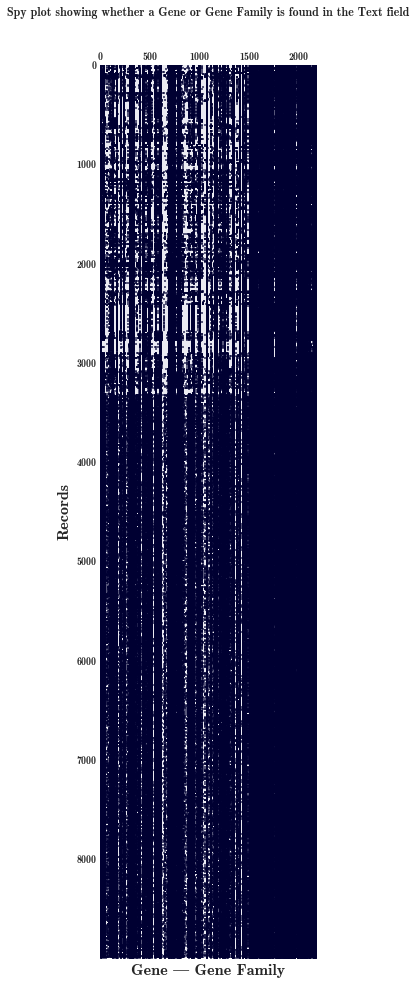

In [740]:
plt.figure(figsize=(16,16))
gene_matrix = all_[[ x for x in all_.columns if x.startswith('F-GT-') ]].values
gene_families_matrix = all_[[ x for x in all_.columns if x.startswith('F-GFT-') ]].values
plt.spy(np.hstack([gene_matrix, gene_families_matrix]), markersize=1)
plt.title('Spy plot showing whether a Gene or Gene Family is found in the Text field')
plt.xlabel('Gene | Gene Family', fontsize=16)
plt.ylabel('Records', fontsize=16)
plt.show()

### Genes are on the left side of the matrix, and gene families are on the right side. Gene families seem to appear in more Text fields, which makes sense: we're stripping the numbers from the end of the genes when creating the families, so two text fields which only contain "BRCA1" and "BRCA2", respectively, will both contain "BRCA".
### The spy plot for Variations:

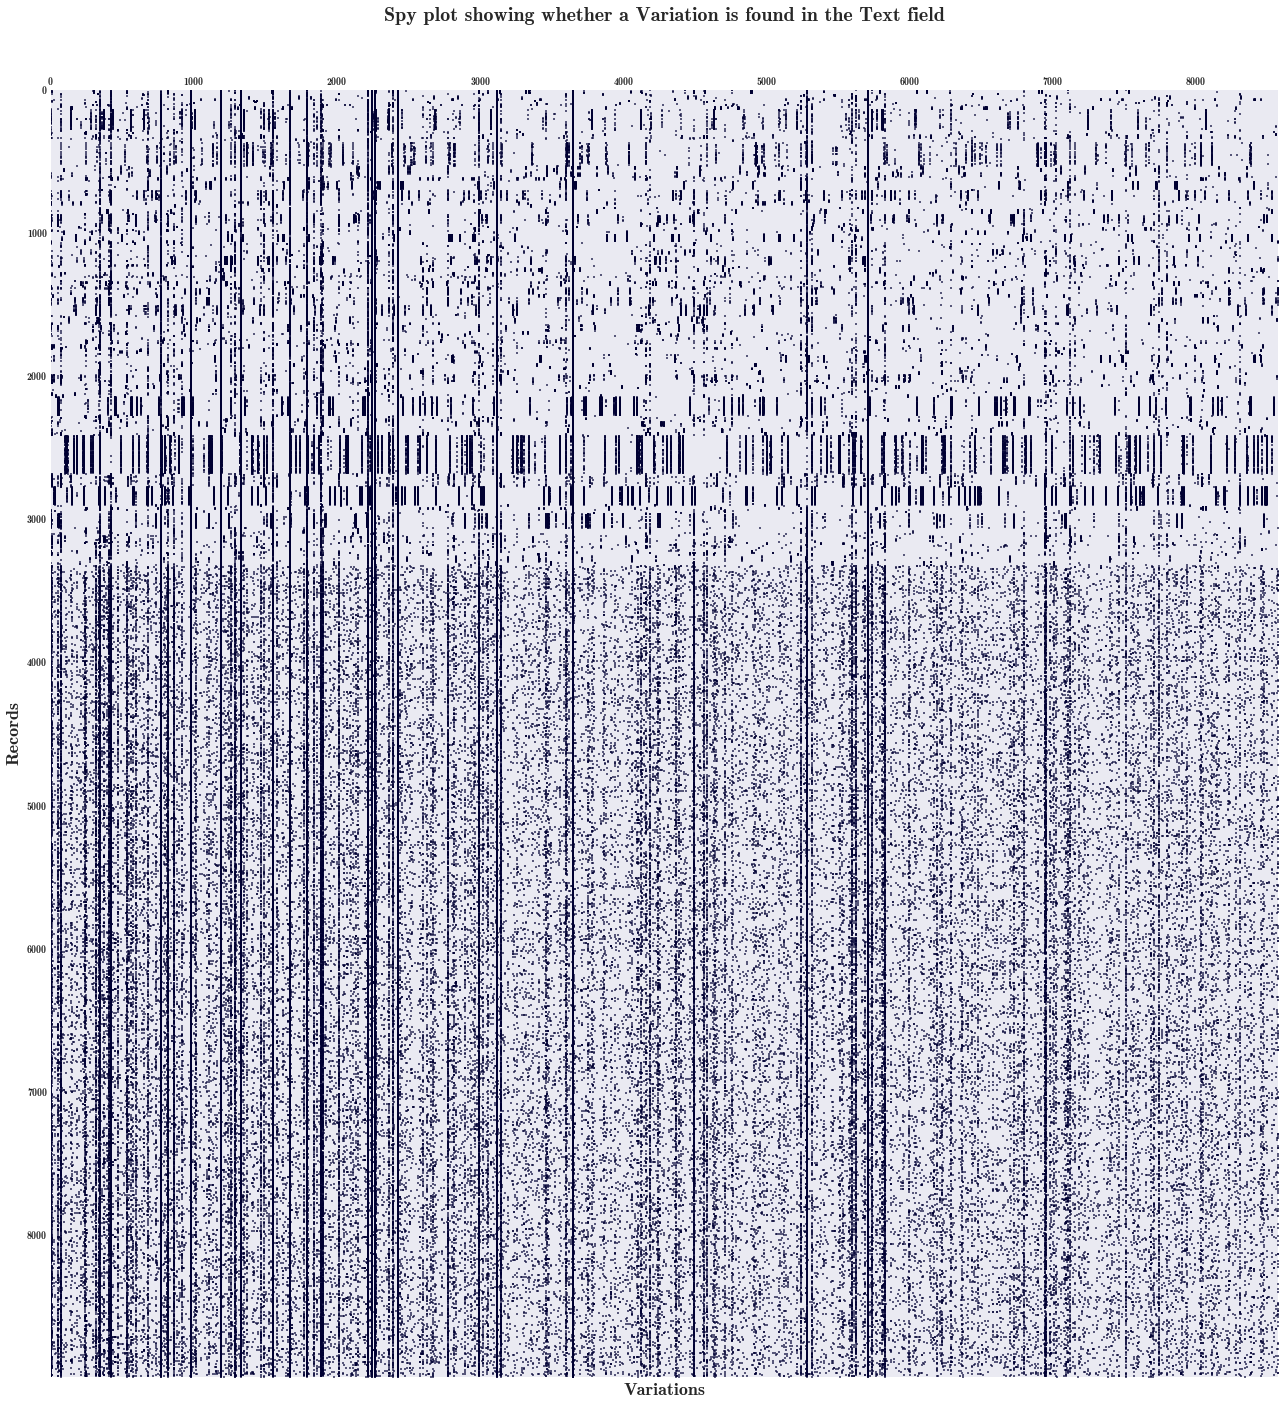

In [729]:
plt.figure(figsize=(22,28))
plt.spy(all_[[ x for x in all_.columns if x.startswith('F-VT-') ]].values, markersize=1)
plt.title('Spy plot showing whether a Variation is found in the Text field', fontsize=20)
plt.xlabel('Variations', fontsize=18)
plt.ylabel('Records', fontsize=18)
plt.show()

### Comparing the gene and variation spy plots, it's apparent that genes show up in more texts than do variations. It also looks like a handful of variations show up in all of the records. These may just be a result of variations which are part of common words. A way to avoid this may be to tokenize the text set before performing the search, and only looking for exact matches.
### The distribution seems to validate the idea of shared variations between different text fields. An interesting feature visible in the plot is the difference between variation appearances within the training and text data, visible at the split around Records = 3321 on the vertical axis.

## Features: Number of times the primary mutation types are mentioned in the text
#### Here, I'm looking for mentions of words like "substitution", "deletion", and "truncation". I'll be applying the previously-chosen stemmer to this list of words before searching through the text.

In [558]:
mutation_terms = ['deletion','insertion','splice','amplification','fusion',
                  'truncation','overexpression','substitution']
stemmed_terms = [ str(porter_stemmer.stem(term)) for term in mutation_terms ]
print 'Stemmed terms: {}'.format(stemmed_terms)

for term in stemmed_terms:
    all_['F-MT-{}'.format(term)] = all_['Text Lower'].apply(lambda x: np.log10(1.0 + x.count(term)) / np.log10(1.0 + len(x)))

Stemmed terms: ['delet', 'insert', 'splice', 'amplif', 'fusion', 'truncat', 'overexpress', 'substitut']


# Part 3: Model Optimization
### I'm going to use an XGBClassifier for testing these features. I'm choosing this tree boosting model because many of these features are categorical, and because this model tends to do well with sparse features. It's also performant, which is good for rapid testing. I'll be using mostly default parameters and saving any tuning until later.
### First, I'm going to create a method which automates the accuracy and submissions generation. This should be able to use any model which utilizes the sklearn API, but I'll default it to XGBoost. NOTE: I ran out of time to implement the general model option, but it should be fairly easy to do.

In [559]:
def training_columns(df):
    ret_df = df[df['Class'].notnull()]
    return ret_df[[name for name in list(df.columns) if name.startswith('F-')]]

def test_columns(df):
    ret_df = df[df['Class'].isnull()]
    return ret_df[[name for name in list(df.columns) if name.startswith('F-')]]

def test_ids(df):
    return df[df['Class'].isnull()]['ID'].values

def test_model(X, Y, ids, X_test=None, model_in=None, folds=5, param={}, drop=None, submit=False, plot=True, verbose=2):
    a = time.time()

    params = {}
    params['eta'] = 0.1
    params['max_depth'] = 4
    params['silent'] = 1
    params['nthread'] = 12
    params['objective'] = 'multi:softprob'
    params['num_class'] = 9
    params['eval_metric'] = 'mlogloss'
    params['reg_lambda'] = 1.0
    params['reg_alpha'] = 1.0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params.update(param)

    Y = Y - 1
    log_loss_val = []
    for fold in range(folds):
        xt, xv, yt, yv = model_selection.train_test_split(X, Y, test_size=0.20, random_state=random.randint(1,100))
        if not model_in:
            input_train = xgboost.DMatrix(xt, label=yt)
            input_val = xgboost.DMatrix(xv, label=yv)
            input_val_only = xgboost.DMatrix(xv)
            input_test = xgboost.DMatrix(X_test)
            input_all = xgboost.DMatrix(X)
            eval_ = [(input_train, 'train'), (input_val, 'val')]
            model = xgboost.train(params=params, 
                              dtrain=input_train, 
                              num_boost_round=500, 
                              verbose_eval=100 if verbose > 1 else False, 
                              evals=eval_, 
                              early_stopping_rounds=100)
        else:
            pass
            # TODO: fit a generalized model
        log_loss_score = metrics.log_loss(yv, model.predict(input_val_only, ntree_limit=model.best_ntree_limit), labels = list(range(9)))
        if verbose > 0: print 'Validation log loss at fold {}: {}'.format(fold, log_loss_score)
        log_loss_val.append(log_loss_score)
        if submit:
            pred_sub = model.predict(input_test, ntree_limit=model.best_ntree_limit)
            if fold == 0:
                preds_sub = copy.deepcopy(pred_sub)
            else:
                preds_sub += pred_sub
        if plot:
            pred_plot = model.predict(input_all, ntree_limit=model.best_ntree_limit)
            if fold == 0:
                preds_plot = copy.deepcopy(pred_plot)
            else:
                preds_plot += pred_plot

    if verbose > 1: print 'Time to finish training and predictions: {} seconds'.format(time.time() - a)
    if submit: preds_sub /= float(folds)
    if plot: preds_plot /= float(folds)

    mean_log_loss_val = np.mean(log_loss_val)
    class_map = np.array(sorted(set(Y)))
    Y = Y + 1

    if plot:
        preds_plot_mapped = class_map[np.argmax(preds_plot, axis=1)] + 1
        if verbose > 0: print '\nAveraged train + validation log loss: {}'.format(log_loss(Y, preds_plot))
        if verbose > 0: print 'Averaged validation log loss:         {}'.format(mean_log_loss_val)
        if verbose > 0: print 'Averaged accuracy:                    {}'.format(accuracy_score(Y, preds_plot_mapped))
        skplt.plot_confusion_matrix(Y, preds_plot_mapped)
    if submit:
        preds_sub /= float(folds)
        submission = pd.DataFrame(preds_sub, columns=['class'+str(c+1) for c in range(9)])
        submission['ID'] = ids
        submission.to_csv('submission_{}.csv'.format(datetime.datetime.today()), index=False)
    return mean_log_loss_val

ids = test_ids(all_)

[0]	train-mlogloss:2.0382	val-mlogloss:2.06772
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 100 rounds.
[100]	train-mlogloss:0.371415	val-mlogloss:1.00222
Stopping. Best iteration:
[97]	train-mlogloss:0.380445	val-mlogloss:1.00059

Validation log loss at fold 0: 1.00059012263
[0]	train-mlogloss:2.04085	val-mlogloss:2.06774
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 100 rounds.
[100]	train-mlogloss:0.379286	val-mlogloss:0.939521
[200]	train-mlogloss:0.202818	val-mlogloss:0.944028
Stopping. Best iteration:
[134]	train-mlogloss:0.302729	val-mlogloss:0.935899

Validation log loss at fold 1: 0.935899152385
[0]	train-mlogloss:2.0411	val-mlogloss:2.06945
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 100 rounds.
[100]	

0.96728304181584068

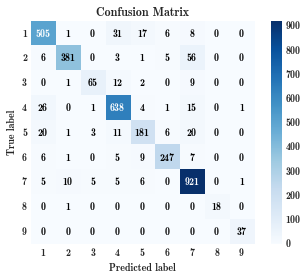

In [560]:
y = np.array(train['Class'].tolist())
kevin_train = training_columns(all_)
kevin_test = test_columns(all_)

_ = test_model(X=kevin_train, 
               X_test=kevin_test, 
               Y=y, ids=ids, folds=5, verbose=2, plot=True, submit=True)

### That took quite a while to train. Let's see if we can retain the same accuracy, but reduce the number of features. I'm mainly looking to cut down the text count feature set for genes, gene families, and amino acids. We'll use a truncated SVD for dimensionality reduction.

Reduced text search feature dimensionality from 10750 to 50.
Validation log loss at fold 0: 0.890086633873
Validation log loss at fold 1: 0.929402458896
Validation log loss at fold 2: 0.869160447816
Validation log loss at fold 3: 0.869160447816
Validation log loss at fold 4: 0.875829896805

Averaged train + validation log loss: 0.343657737108
Averaged validation log loss:         0.886727977041
Averaged accuracy:                    0.921710328214


0.88672797704101503

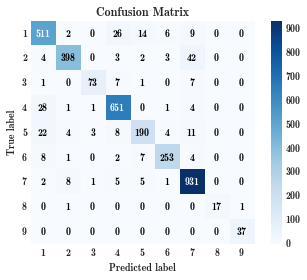

In [592]:
def special_feat(df):
    return df[[name for name in list(df.columns) if name.startswith('F-GT-')
                                                     or name.startswith('F-GFT-') or name.startswith('F-VT')]]

def regular_feat(df):
    return df[[name for name in list(df.columns) if not (name.startswith('F-GT-')
                                                             or name.startswith('F-GFT-') or name.startswith('F-VT-'))]]

def get_manual_features(df, num_dims, verbose=0):
    all_train = training_columns(df)
    all_test = test_columns(df)

    reg_train = regular_feat(all_train).values
    spec_train = special_feat(all_train).values
    reg_test = regular_feat(all_test).values
    spec_test = special_feat(all_test).values

    feat_truncator = TruncatedSVD(n_components=num_dims, n_iter=30)
    spec_train_trunc = feat_truncator.fit_transform(spec_train)
    spec_test_trunc = feat_truncator.transform(spec_test)

    print 'Reduced text search feature dimensionality from {} to {}.' \
                    .format(spec_train.shape[1], spec_train_trunc.shape[1])
    return (np.hstack([reg_train, spec_train_trunc]), np.hstack([reg_test, spec_test_trunc]))

manual_train, manual_test = get_manual_features(all_, num_dims=50, verbose=1)

_ = test_model(X=manual_train, 
               X_test=manual_test, 
               Y=y, ids=ids, folds=5, verbose=1, plot=True, submit=True)

### Neat - It looks like these features do alright. The Kaggle submission yielded a loss of about 0.72, which put the submission in the top 400 at the time (out of roughly 1000). Looking at the output from the training process, it looks like there is a bit of a gap between the logloss of the training and validation steps. This is a sign of overfitting, but I'll deal with that a bit later during the tuning phase.
### The model also seems to do surprisingly well with the underpopulated classes 8 and 9. The manual features must have extracted useful information which works well for these classes. This is a relief - it looks like we don't have to worry too much about the class imbalance!
### I'd like to featurize the Text field next. Doc2Vec seems like a reasonable place to start. Given a list of tokenized words, we'd like to generate a feature vector which represents our document, or group of text. This is what Doc2Vec provides - it's similar to Word2Vec, but encodes additional information about the document ID in the input layer.
### This is a pretty data-hungry algorithm, so I'm going to train this on both training and test data. Doing this comes with the risk of overfitting the model since we don't have anything new with which to compare the model. However, it is still an unsupervised method, and I think this is a good approach given the relatively small amount of text data available.

In [593]:
def create_sentences(rows):
    sentences = []
    i = 0
    for index, row in rows.iteritems():
        sentences.append(LabeledSentence(row, ['sentence_{}'.format(str(i))]))
        i += 1
    return sentences

sentences = create_sentences(all_['Text Tok'])
print 'Created {} sentences'.format(len(sentences))

Created 8989 sentences


### I'm including the duplicate texts in the Doc2Vec input. There are 1400 Text fields which are dulicated at least once out of 9000 input records, so this may not be the safest move - we may bias the model in favor of the words and context found in some of the more duplicated records. But, I'll start with this for now.

In [594]:
def get_doc2vec_model(sentences, num_feat=100, iter_=8, window=10, negative=8, min_count=10, sample=1e-5):
    d2v_filename = 'doc2vec_{}_{}_{}_{}_{}_{}'.format(num_feat, iter_, window, negative, min_count, sample)
    try:
        d2v = Doc2Vec.load(d2v_filename)
        print 'Loaded trained model from {}'.format(d2v_filename)
    except Exception as e:
        print 'Exception encountered: {}. Training new model.'.format(e)
        a = time.time()
        d2v = Doc2Vec(min_count=min_count, window=window, size=num_feat, negative=negative, 
                      iter=iter_,sample=sample, workers=6)
        d2v.build_vocab(sentences)
        d2v.train(sentences, epochs=iter_, total_examples=d2v.corpus_count)
        d2v.save(d2v_filename)
        print 'Took {} seconds to train doc2vec'.format(time.time() - a)
    return d2v

def get_doc2vec_features(d2vmodel):
    doc2vec_train = np.array([ d2v.docvecs['sentence_{}'.format(i)] for i in range(0, num_train) ])
    doc2vec_test = np.array([ d2v.docvecs['sentence_{}'.format(i)] for i in range(num_train, len(all_)) ])
    return (doc2vec_train, doc2vec_test)

Exception encountered: [Errno 2] No such file or directory: 'doc2vec_100_8_10_8_10_1e-05'. Training new model.
Took 188.174406767 seconds to train doc2vec
Validation log loss at fold 0: 1.17168535004
Validation log loss at fold 1: 1.07844299978
Validation log loss at fold 2: 1.0439096939
Validation log loss at fold 3: 1.0439096939
Validation log loss at fold 4: 1.07844299978

Averaged train + validation log loss: 0.286845401975
Averaged validation log loss:         1.08327814748
Averaged accuracy:                    0.963264077085


1.0832781474790851

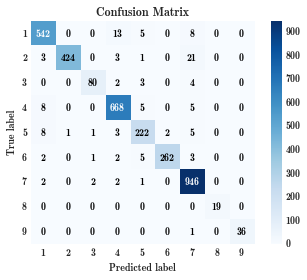

In [595]:
d2v = get_doc2vec_model(sentences, num_feat=100)
doc2vec_train, doc2vec_test = get_doc2vec_features(d2v)

_ = test_model(X=doc2vec_train, 
               X_test=doc2vec_test, 
               Y=y, ids=ids, folds=5, verbose=1, plot=True, submit=True)

### It looks like there is quite a bit of overfitting here. Let's run a model with both the Doc2Vec features and the manual features.

Validation log loss at fold 0: 1.02519251372
Validation log loss at fold 1: 1.07417907599
Validation log loss at fold 2: 1.12335104765
Validation log loss at fold 3: 1.13245020626
Validation log loss at fold 4: 1.12546046494

Averaged train + validation log loss: 0.359945840559
Averaged validation log loss:         1.09612666171
Averaged accuracy:                    0.953327311051


1.0961266617107213

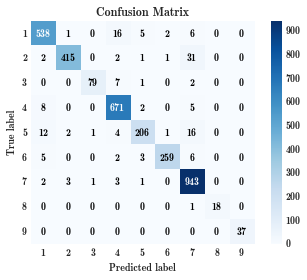

In [596]:
_ = test_model(X=np.hstack([reg_train, spec_train_trunc, doc2vec_train]), 
               X_test=np.hstack([reg_test, spec_test_trunc, doc2vec_test]), 
               Y=y, ids=ids, folds=5, verbose=1, plot=True, submit=True)

### Again, we're seeing a lot of overfitting. There are ways we can mitigate this, including tuning of the Doc2Vec features as well as the model itself. Before we do that, I'd like to investigate how well a TF-IDF works with this data. As mentioned in the discovery section, a manual tokenizing may remove some words that actually contain information within the text. I'm going to run this on the full text for each record with the built-in tokenizer, and see how that performs.

In [620]:
def get_tfidf_features(df, num_dims):
    vectorizer = TfidfVectorizer(analyzer="word", 
                                 tokenizer=word_tokenize, 
                                 stop_words='english')

    vect_train_words = vectorizer.fit_transform(all_.iloc[:num_train]['Text'])
    vect_test_words = vectorizer.transform(all_.iloc[num_train:]['Text'])

    truncator = TruncatedSVD(n_components=num_dims, n_iter=20)
    tfidf_train = truncator.fit_transform(vect_train_words)
    tfidf_test = truncator.transform(vect_test_words)

    return (tfidf_train, tfidf_test)

100
Validation log loss at fold 0: 0.985488966836
Validation log loss at fold 1: 0.988796752201
Validation log loss at fold 2: 0.961046100411
Validation log loss at fold 3: 0.974501184853
Validation log loss at fold 4: 0.961046100411

Averaged train + validation log loss: 0.528605747608
Averaged validation log loss:         0.974175820942
Averaged accuracy:                    0.836193917495


0.97417582094249211

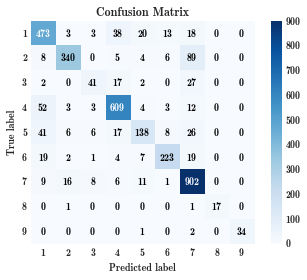

In [621]:
tfidf_train, tfidf_test = get_tfidf_features(all_, num_dims=100)
_ = test_model(X=tfidf_train, 
               X_test=tfidf_test, 
               Y=y, ids=ids, folds=5, verbose=1, plot=True, submit=True)

### That performs a bit better than the Doc2Vec feature set on the validation data. Let's add the manual feature sets to the TF-IDF set:

Validation log loss at fold 0: 1.0354667132
Validation log loss at fold 1: 0.970158923734
Validation log loss at fold 2: 1.02280142991
Validation log loss at fold 3: 0.999982579629
Validation log loss at fold 4: 1.06203602967

Averaged train + validation log loss: 0.516869730442
Averaged validation log loss:         1.01808913523
Averaged accuracy:                    0.845528455285


1.0180891352295316

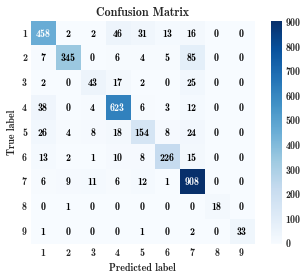

In [622]:
_ = test_model(X=np.hstack([reg_train, spec_train_trunc, tfidf_train]), 
               X_test=np.hstack([reg_test, spec_test_trunc, tfidf_test]), 
               Y=y, ids=ids, folds=5, verbose=1, plot=True, submit=True)

### Finally, using all of the feature sets derived so far:

Validation log loss at fold 0: 0.976281655409
Validation log loss at fold 1: 0.988497455847
Validation log loss at fold 2: 0.94522579671
Validation log loss at fold 3: 1.04317018107
Validation log loss at fold 4: 0.970360182202

Averaged train + validation log loss: 0.377262112509
Averaged validation log loss:         0.984707054247
Averaged accuracy:                    0.936464920205


0.98470705424652505

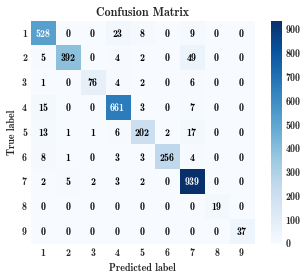

In [623]:
_ = test_model(X=np.hstack([reg_train, spec_train_trunc, tfidf_train, doc2vec_train]), 
               X_test=np.hstack([reg_test, spec_test_trunc, tfidf_test, doc2vec_test]), 
               Y=y, ids=ids, folds=5, verbose=1, plot=True, submit=True)

### Aside from some general overfitting with the Doc2Vec method, I'm happy with this set of features. Normally I'd perform a more rigorous analysis of which features we could use via PCA or SVD. Since we've already used SVD for 3 of the 4 feature sets, we've already done some of this, so I'll focus on tuning hyperparameters to try and achieve better validation and test accuracy.
### The Kaggle limit of 5 submissions per day limits the amount of test set validation I can perform, so I focused most of the efforts on increasing validation set accuracy.
### We already have a pretty large amount of hyperparameters - inputs for Doc2Vec, TF-IDF, and the model itself, as well as the dimensionality reduction performed on existing feature sets. I'm limiting this parameter search to those inputs which I believe have the greatest impact. Since I'm looking to optimize parameters beyond that of the model itself, I'll create my own parameter search method:

In [564]:
man_dict, d2v_dict, tfidf_dict, val_dict, val_dict_model = {}, {}, {}, {}, {}
constants = (y, all_, ids, sentences)

In [687]:
def dimension_parameter_search(params, *constants):
    y, df, ids, sentences = constants
    man_dims, d2v_dims, d2v_iter, d2v_window, d2v_count, tfidf_dims = ( int(x) for x in params )
    parameter_set = tuple([ int(x) for x in params ])
    # the below is hacky - the brute() method creates duplicates when constant tuple ranges are specified
    prev_val = val_dict.get(parameter_set)
    if prev_val:
        return prev_val

    # Manual features
    man_feat = man_dict.get(man_dims)
    if not man_feat:
        man_feat = get_manual_features(df, man_dims)
        man_dict[man_dims] = man_feat
    man_train, man_test = man_feat

    # doc2vec
    d2v_params = (d2v_dims, d2v_iter, d2v_window, d2v_count)
    d2v = d2v_dict.get(d2v_params)
    if not d2v:
        d2v = get_doc2vec_model(sentences, num_feat=d2v_dims, iter_=d2v_iter, window=d2v_window, min_count=d2v_count)
        d2v_dict[d2v_params] = d2v
    doc2vec_train, doc2vec_test = get_doc2vec_features(d2v)

    # TF-IDF
    tfidf_feat = tfidf_dict.get(tfidf_dims)
    if not tfidf_feat:
        tfidf_feat = get_tfidf_features(df, tfidf_dims)
        tfidf_dict[tfidf_dims] = tfidf_feat
    tfidf_train, tfidf_test = tfidf_feat

    # Model
    val = test_model(X=np.hstack([man_train, doc2vec_train, tfidf_train]), 
                     X_test=np.hstack([man_test, doc2vec_test, tfidf_test]), 
                     Y=y, ids=ids, folds=10, verbose=0, plot=False, submit=False)
    val_dict[parameter_set] = val
    print 'val_log_loss for parameter set {} = {}'.format(parameter_set, val)
    return val

### Unfortunately the brute() method only accepts slices, which cannot accept nonlinear ranges - e.g. [1, 10, 100]. I can get around this by scaling inside the method if needed. Also, due to the way it creates a grid, I'm running into memory issues when trying to include too many parameters, so I'm going to split the parameter search into two parts: the optimal dimensionality reduction for the feature sets, and the optimal model regularization using the results from the first part.

In [688]:
# Test these feature set dimensionality values
man_dims    = slice(50, 101, 50)
d2v_dims    = slice(50, 101, 50)
d2v_iter    = (8, 8)
d2v_window  = (10, 10)
d2v_count   = (10, 10)
tfidf_dims  = slice(50, 151, 50)

rranges = (man_dims, d2v_dims, d2v_iter, d2v_window, d2v_count, tfidf_dims)

resbrute = optimize.brute(dimension_parameter_search, rranges, args=constants, full_output=True, finish=None)
print '\nBest parameter combination: {}'.format(resbrute[0])
print 'Mean validation log-loss for this combination: {}'.format(resbrute[1])

val_log_loss for parameter set (50, 50, 8, 10, 10, 50) = 0.938382982926
val_log_loss for parameter set (50, 50, 8, 10, 10, 100) = 0.946477656155
val_log_loss for parameter set (50, 50, 8, 10, 10, 150) = 0.918789938286
val_log_loss for parameter set (50, 100, 8, 10, 10, 50) = 0.939765775516
val_log_loss for parameter set (50, 100, 8, 10, 10, 100) = 0.910644303706
val_log_loss for parameter set (50, 100, 8, 10, 10, 150) = 0.913064895632
val_log_loss for parameter set (100, 50, 8, 10, 10, 50) = 0.939833700284
val_log_loss for parameter set (100, 50, 8, 10, 10, 100) = 0.951954234327
val_log_loss for parameter set (100, 50, 8, 10, 10, 150) = 0.935205373197
val_log_loss for parameter set (100, 100, 8, 10, 10, 50) = 0.944739811721
val_log_loss for parameter set (100, 100, 8, 10, 10, 100) = 0.953370276697
val_log_loss for parameter set (100, 100, 8, 10, 10, 150) = 0.944086770323

Best parameter combination: [  50.  100.    8.   10.   10.  100.]
Mean validation log-loss for this combination: 0.

### From this modest parameter search, the feature vector sizes for the manual, Doc2Vec, and TF-IDF feature sets have optimal values at 50, 100, and 100, respectively. Now let's optimize the regularization parameters of the model using these feature set dimension input values:

In [689]:
optimal_man_dims = 50
optimal_d2v_dims = 100
optimal_tfidf_dims = 100

In [690]:
def model_parameter_search(params, *constants):
    y, df, ids, sentences, man_feat, doc2vec_feat, tfidf_feat = constants
    max_depth, reg_lambda, reg_alpha, subsample, colsample = params
    max_depth = int(max_depth)
    parameter_set = tuple(params)
    prev_val = val_dict_model.get(parameter_set)
    if prev_val:
        return prev_val

    # Feature sets
    man_train, man_test = man_feat
    doc2vec_train, doc2vec_test = doc2vec_feat
    tfidf_train, tfidf_test = tfidf_feat

    # Model
    model_params = {'max_depth': max_depth,
                    'reg_lambda': reg_lambda,
                    'reg_alpha': reg_alpha,
                    'subsample': subsample,
                    'colsample': colsample}
    val = test_model(X=np.hstack([man_train, doc2vec_train, tfidf_train]), 
                     X_test=np.hstack([man_test, doc2vec_test, tfidf_test]), 
                     Y=y, ids=ids, folds=5, param=model_params, verbose=0, plot=False, submit=False)
    val_dict_model[parameter_set] = val
    print 'val_log_loss for parameter set {} = {}'.format(parameter_set, val)
    return val

In [691]:
# Use optimal feature set dimensions from previous parameter search
man_feat = man_dict.get(optimal_man_dims)
d2v_params = (optimal_d2v_dims, 8, 10, 10)
d2v = d2v_dict.get(d2v_params)
doc2vec_feat = get_doc2vec_features(d2v)
tfidf_feat = tfidf_dict.get(optimal_tfidf_dims)

# Test these model regularization values
max_depth   = slice(4, 7, 2)
reg_lambda  = slice(0.0, 1.1, 1.0)
reg_alpha   = slice(0.0, 1.1, 1.0)
subsample   = slice(0.5, 1.1, 0.5)
colsample   = slice(0.5, 1.1, 0.5)

rranges = (max_depth, reg_lambda, reg_alpha, subsample, colsample)
constants_model = (y, all_, ids, sentences, man_feat, doc2vec_feat, tfidf_feat)

resbrute = optimize.brute(model_parameter_search, rranges, args=constants_model, full_output=True, finish=None)
print 'Best parameter combination: {}'.format(resbrute[0])
print 'Mean validation log-loss for this combination: {}'.format(resbrute[1])

val_log_loss for parameter set (4.0, 0.0, 0.0, 0.5, 0.5) = 0.929764949988
val_log_loss for parameter set (4.0, 0.0, 0.0, 0.5, 1.0) = 0.943309156069
val_log_loss for parameter set (4.0, 0.0, 0.0, 1.0, 0.5) = 0.92880485516
val_log_loss for parameter set (4.0, 0.0, 0.0, 1.0, 1.0) = 0.919271639084
val_log_loss for parameter set (4.0, 0.0, 1.0, 0.5, 0.5) = 0.928679658193
val_log_loss for parameter set (4.0, 0.0, 1.0, 0.5, 1.0) = 0.924074952486
val_log_loss for parameter set (4.0, 0.0, 1.0, 1.0, 0.5) = 0.902570737717
val_log_loss for parameter set (4.0, 0.0, 1.0, 1.0, 1.0) = 0.927039649579
val_log_loss for parameter set (4.0, 1.0, 0.0, 0.5, 0.5) = 0.919495556681
val_log_loss for parameter set (4.0, 1.0, 0.0, 0.5, 1.0) = 0.934696529847
val_log_loss for parameter set (4.0, 1.0, 0.0, 1.0, 0.5) = 0.949288988594
val_log_loss for parameter set (4.0, 1.0, 0.0, 1.0, 1.0) = 0.962196017408
val_log_loss for parameter set (4.0, 1.0, 1.0, 0.5, 0.5) = 0.948309677224
val_log_loss for parameter set (4.0, 1.

### Of the values searched, those are the optimal regularization values. Let's try all of our optimal parameters on a model, and submit it:

Validation log loss at fold 0: 0.899446237754
Validation log loss at fold 1: 0.95593344795
Validation log loss at fold 2: 0.968979879176
Validation log loss at fold 3: 0.869785743205
Validation log loss at fold 4: 0.873655682858
Validation log loss at fold 5: 0.922614439574
Validation log loss at fold 6: 0.996583789696
Validation log loss at fold 7: 0.95593344795
Validation log loss at fold 8: 0.916818833162
Validation log loss at fold 9: 0.881306138328

Averaged train + validation log loss: 0.321009080418
Averaged validation log loss:         0.924105763965
Averaged accuracy:                    0.958747365251


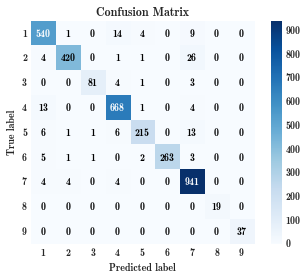

In [694]:
man_train, man_test = man_feat
doc2vec_train, doc2vec_test = doc2vec_feat
tfidf_train, tfidf_test = tfidf_feat

model_params = {'max_depth': 4,
                'reg_lambda': 0.0,
                'reg_alpha': 1.0,
                'subsample': 1.0,
                'colsample_bytree': 0.5}

_ = test_model(X=np.hstack([man_train, doc2vec_train, tfidf_train]), 
           X_test=np.hstack([man_test, doc2vec_test, tfidf_test]), 
           Y=y, ids=ids, folds=10, param=model_params, verbose=1, plot=True, submit=True)

### This submission actually generates a log-loss of 0.72519, worse than before! There are many possible reasons for this, but my suspicion is that the overfitting Doc2Vec features are hurting us. Let's try one more using the same hyperparameters, but without the Doc2Vec features:

Validation log loss at fold 0: 0.858052330504
Validation log loss at fold 1: 0.874137754499
Validation log loss at fold 2: 0.974458396116
Validation log loss at fold 3: 0.869828739237
Validation log loss at fold 4: 0.92016530733
Validation log loss at fold 5: 0.822000926165
Validation log loss at fold 6: 0.891605078661
Validation log loss at fold 7: 0.927110574361
Validation log loss at fold 8: 0.907708670049
Validation log loss at fold 9: 0.861985700682

Averaged train + validation log loss: 0.348916069488
Averaged validation log loss:         0.89070534776
Averaged accuracy:                    0.927732610659


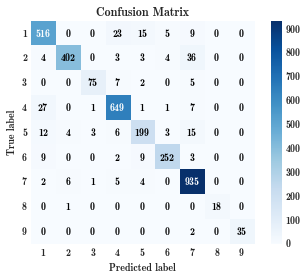

In [695]:
man_train, man_test = man_feat
doc2vec_train, doc2vec_test = doc2vec_feat
tfidf_train, tfidf_test = tfidf_feat

model_params = {'max_depth': 4,
                'reg_lambda': 0.0,
                'reg_alpha': 1.0,
                'subsample': 1.0,
                'colsample_bytree': 0.5}

_ = test_model(X=np.hstack([man_train, tfidf_train]), 
           X_test=np.hstack([man_test, tfidf_test]), 
           Y=y, ids=ids, folds=10, param=model_params, verbose=1, plot=True, submit=True)

### Better this gives a test set log-loss of 0.68341. That's a pretty clear indication that the Doc2Vec analysis is either not appropriate for this data set, or is not quite optimized (or both!).

# Final Thoughts
### There are many more things I'd like to try to increase the accuracy of this predictor. Here are some of the top ones:
#### Perform a more thorough analysis of features based on what the confusion matrix shows we're missing. In particular, the model seems to be mixing up classes 2 and 7. Also, we are misclassifying class 1 as several different predicted classes. My first step towards improving accuracy would be to look at the subset of training data corresponding to these classes and look for more useful signal.
#### Create an ensemble of different model types. Right now I'm using what is essentially an ensemble of several XGBoost models, all with the same parameters but trained on a different subset of the training data, but it's common to increase accuracy by combining the results of diferent model types.
#### Related to the above: due to the time constraints of the project, I didn't have much of a chance to improve my model from the point of view of the test data accuracy. This was due to the fact that Kaggle only allows 5 submissions per day, and so I only had a handful of data points to use for tuning to optimize the test data log-loss. If I had more time, I would use this to reduce overfitting.
#### I'd really like to try running an LSTM on this data set. The sequential nature of the text data may work well with this type of model. Because I was limited by hardware and time, I chose to not try this, but I'm very curious to see how one would perform on the data.
#### The text field is very rich, and I feel that I only scratched the surface of the useful information which can be extracted from it. I'd like to try to locate parts of the text which may be more relevant than the rest. Ideas including taking the first n words before and after a mention of a gene, variation, or mutation type (instead of just counting these mentions as I did here). Also, some of the texts look like they include all parts of the academic paper, including the sections which talk about experimental techniques. These are not as likely to contain useful information, so I'd like to explore filtering these parts out.
#### Aside from Doc2Vec, I didn't really explore using any unsupervised learning methods with this data. I'm curious to see what a clustering technique would yield. This would be a good way to troubleshoot the inaccuracies with classes 2 and 7 mentioned above.
#### My general plan for feature generation is to spend roughly equal amounts of time with manually- and automatically-created features. However, with text-based data, and with large datasets in general, oftentimes research time is better spent employing several automated techniques and choosing which ones perform the best. In addition to the text field I mentioned above, I'd like to employ these methods for the gene and variation fields. A simple one I didn't try is creation of n-grams from each field, which is an easy way to represent the character similarity between two strings. For instance, "BRCA1" and "BRCA2" would share three 2-grams: "BR", "RC", and "CA", as well as two 3-grams and one 4-gram. In this way things like my gene family feature could be automatically encoded.
#### Finally, I'd like to bring in more external data. My Doc2Vec model seemed to work reasonably well on the relatively small amount of data provided, but it would likely perform even better if it were given more training text from the same domain. Ideas include creating a corpus of academic papers which mention gene mutations in the context of cancer, or creating a web scraping script which would gather the text from Wikipedia pages for each gene: https://en.wikipedia.org/wiki/BRCA1. Another option is working from a pre-trained model. I didn't explore explore this method because commonly-available models are trained on general text, which may not translate well to this domain-specific problem, but I would still like to evaluate it. Finally, I'd like to explore tweaking of the input parameters of the Doc2Vec method.

## Thank you for reading through all of this! I enjoyed the task, and learned a few new techniques along the way.
#### Kevin Mandich